In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

transform = transforms.ToTensor()
dataset = CIFAR10(root='./data', train = True, download = True, transform = transform)

# "dataset" is a CIFAR-10 PyTorch Dataset
img, label = dataset[0]
print(type(img), img.shape)   # <class 'torch.Tensor'>, shape: (3, 32, 32)
print("Label index:", label)
print("Class name:", dataset.classes[label])

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s] 


<class 'torch.Tensor'> torch.Size([3, 32, 32])
Label index: 6
Class name: frog


## Loading Dataset and Gathering Required Classes

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

transform = transforms.ToTensor()
dataset = CIFAR10(root='./data', train = True, download = True, transform = transform)

target_classes = ['horse', 'deer', 'airplane']
class_indices = {name: idx for idx, name in enumerate(dataset.classes)}
selected_indices = {name: [] for name in target_classes}

# Select 10 images per class
for i, (img, label) in enumerate(dataset):
    for cls in target_classes:
        if label == class_indices[cls] and len(selected_indices[cls]) < 10:
            selected_indices[cls].append(i)
            
    if all(len(lst) == 10 for lst in selected_indices.values()):
        break

selected_imgs = []
selected_labels = []

for cls, indices in selected_indices.items():
    for idx in indices:
        img, label = dataset[idx]
        selected_imgs.append(img.numpy().transpose(1, 2, 0))  
        # transpose(1, 2, 0) converts image format from CHW (channel, height, width) to HWC (standard image format)
        
        selected_labels.append(label)

X = np.array(selected_imgs)
y = np.array(selected_labels)

print("Data shape:", X.shape)  # (30, 32, 32, 3)
print("Labels:", [dataset.classes[i] for i in y])

Data shape: (30, 32, 32, 3)
Labels: ['horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'horse', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'deer', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane']


<class 'numpy.ndarray'>
Shape: (32, 32, 3)


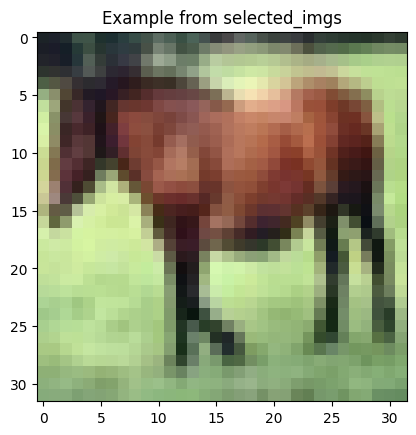

Label index: 7
Class name: horse


In [4]:
print(type(selected_imgs[0]))        # <class 'numpy.ndarray'>
print("Shape:", selected_imgs[0].shape)  # (32, 32, 3)

plt.imshow(selected_imgs[0])
plt.title("Example from selected_imgs")
plt.show()

print("Label index:", selected_labels[0])
print("Class name:", dataset.classes[selected_labels[0]])

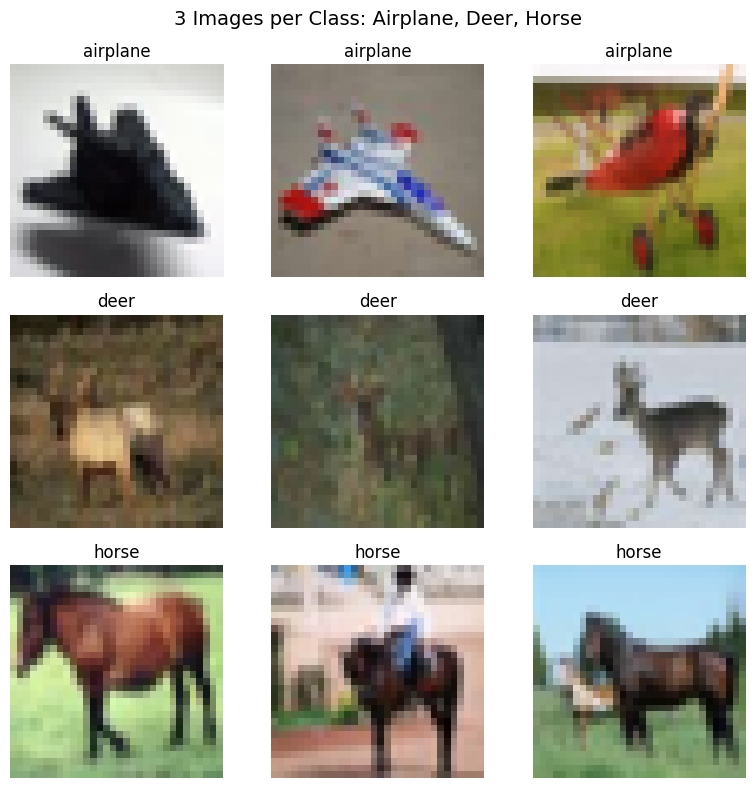

In [6]:
import matplotlib.pyplot as plt

label_names = [dataset.classes[label] for label in selected_labels]

# Plot 3 images from each class
fig, axs = plt.subplots(3, 3, figsize = (8, 8))
fig.suptitle("3 Images per Class: Airplane, Deer, Horse", fontsize = 14)

class_counts = {'airplane': 0, 'deer': 0, 'horse': 0}
row_map = {'airplane': 0, 'deer': 1, 'horse': 2}

for i in range(len(selected_imgs)):
    class_name = label_names[i]
    if class_counts[class_name] < 3:
        row = row_map[class_name]
        col = class_counts[class_name]
        axs[row, col].imshow(selected_imgs[i])
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')
        class_counts[class_name] += 1
        
    if all(v == 3 for v in class_counts.values()):
        break

plt.tight_layout()
plt.show()

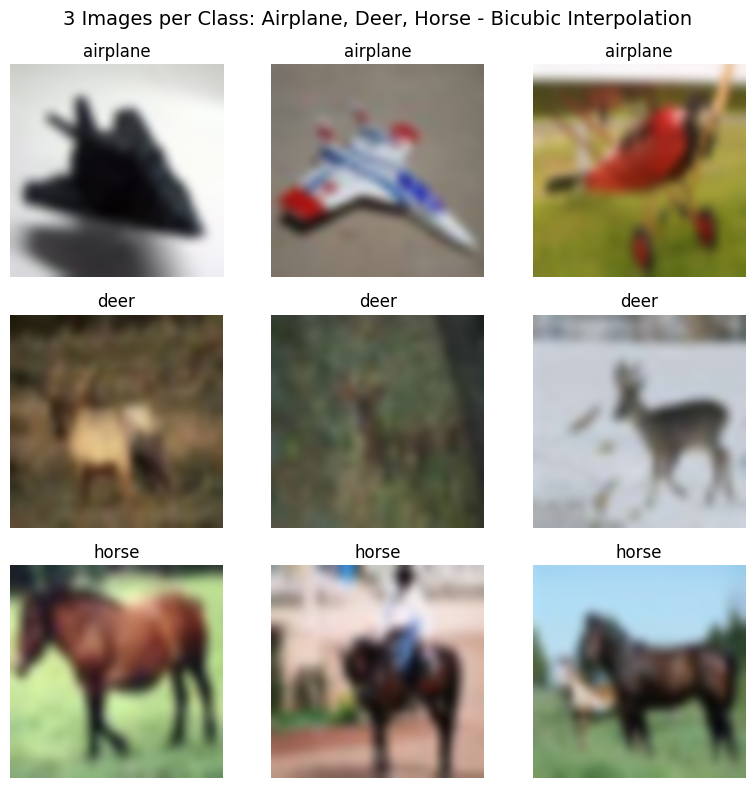

In [7]:
import matplotlib.pyplot as plt

label_names = [dataset.classes[label] for label in selected_labels]

# Plot 3 images from each class
fig, axs = plt.subplots(3, 3, figsize = (8, 8))
fig.suptitle("3 Images per Class: Airplane, Deer, Horse - Bicubic Interpolation", fontsize = 14)

class_counts = {'airplane': 0, 'deer': 0, 'horse': 0}
row_map = {'airplane': 0, 'deer': 1, 'horse': 2}

for i in range(len(selected_imgs)):
    class_name = label_names[i]
    if class_counts[class_name] < 3:
        row = row_map[class_name]
        col = class_counts[class_name]
        axs[row, col].imshow(selected_imgs[i], interpolation = 'bicubic') # interpolation = 'nearest', 'bilinear', 'bicubic'
        axs[row, col].set_title(class_name)
        axs[row, col].axis('off')
        class_counts[class_name] += 1
        
    if all(v == 3 for v in class_counts.values()):
        break

plt.tight_layout()
plt.show()

## Image Array in each color space [Preparation]

In [9]:
from PIL import Image
import numpy as np
import cv2

bicubic_imgs = []

# Resize all images to 32×32 using Bicubic interpolation
for img in selected_imgs:
    img_resized = Image.fromarray((img * 255).astype(np.uint8)).resize((32, 32), Image.BICUBIC)
    bicubic_imgs.append(np.array(img_resized))

X_rgb = np.array(bicubic_imgs).reshape(30, -1)  # Shape: (30, 3072)

hsv_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in bicubic_imgs]
X_hsv = np.array(hsv_imgs).reshape(30, -1) # Shape: (30, 3072)

lab_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in bicubic_imgs]
X_lab = np.array(lab_imgs).reshape(30, -1)  # Shape: (30, 3072)

yCrCb_imgs = [cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) for img in bicubic_imgs]
X_yCrCb = np.array(yCrCb_imgs).reshape(30, -1)  # Shape: (30, 3072)

print("Final shape for clustering:", X_rgb.shape, X_lab.shape, X_hsv.shape, X_yCrCb.shape)

Final shape for clustering: (30, 3072) (30, 3072) (30, 3072) (30, 3072)


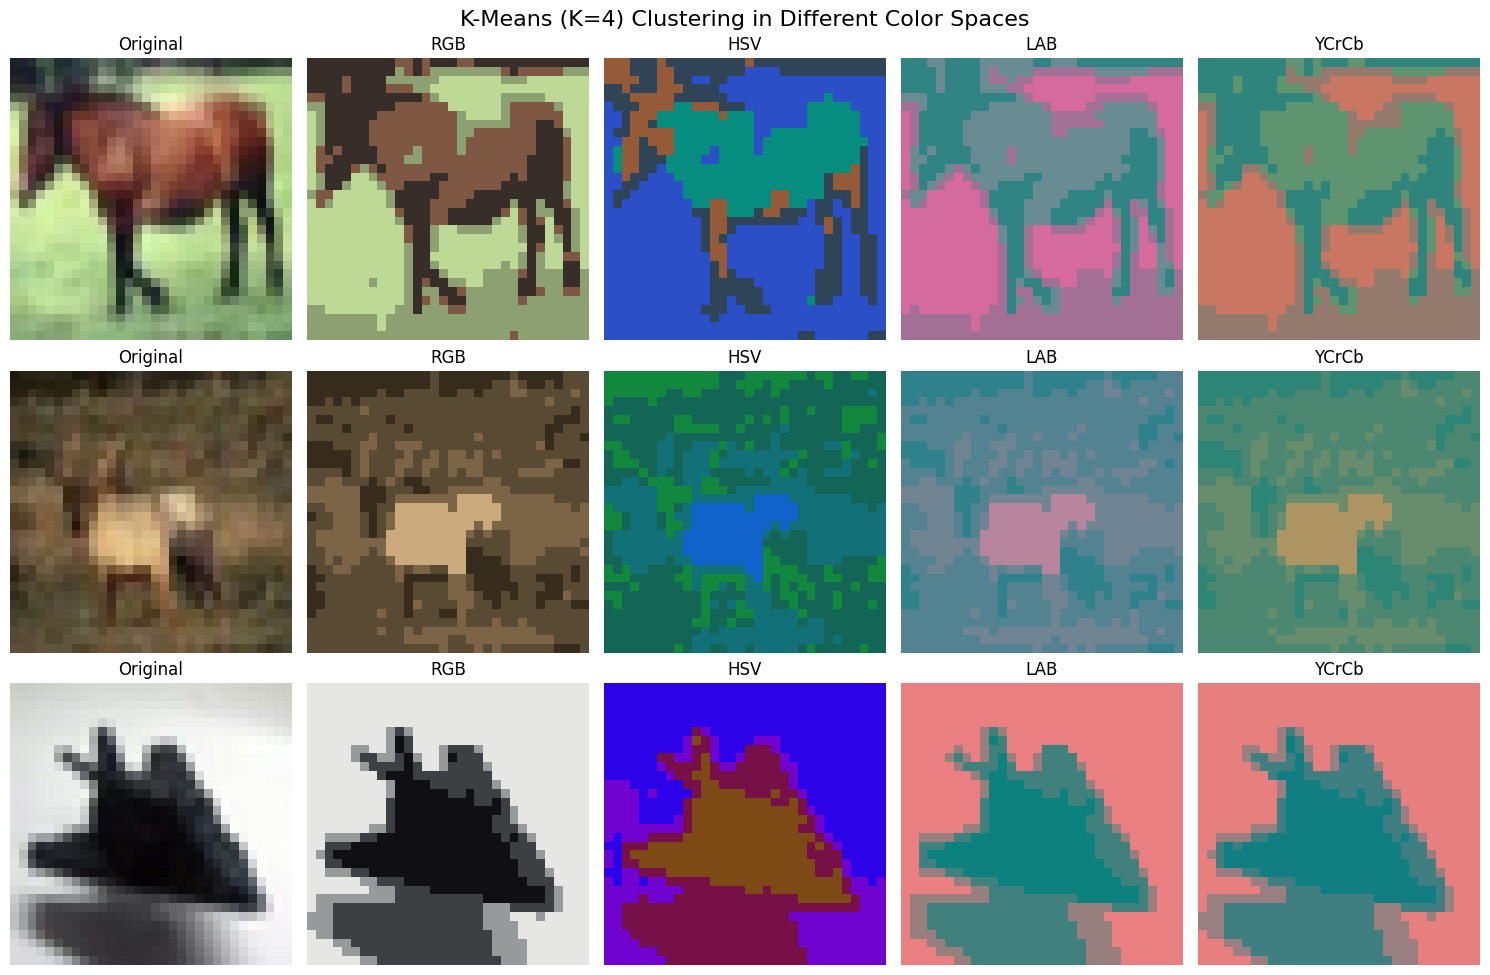

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use image indices for each class (e.g., 0 = airplane, 10 = deer, 20 = horse)
selected_indices = [0, 10, 20]
color_spaces = ['RGB', 'HSV', 'LAB', 'YCrCb']
X_all = [X_rgb, X_hsv, X_lab, X_yCrCb]

fig, axs = plt.subplots(3, 5, figsize = (15, 10))
fig.suptitle("K-Means (K=4) Clustering in Different Color Spaces", fontsize = 16)

for row, img_idx in enumerate(selected_indices):
    # Original image
    axs[row, 0].imshow(bicubic_imgs[img_idx])
    axs[row, 0].set_title("Original")
    axs[row, 0].axis("off")

    # Clustering in each color space
    for col, (X, space) in enumerate(zip(X_all, color_spaces)):
        pixels = X[img_idx].reshape(-1, 3) 
        # Shape (1024, 3) -> 1024 pixels, each with 3 color values (R, G, B or HSV/LAB/YCrCb).
        
        kmeans = KMeans(n_clusters = 4, n_init = 'auto', random_state = 42)
        labels = kmeans.fit_predict(pixels)
        clustered = kmeans.cluster_centers_[labels].reshape(32, 32, 3).astype(np.uint8)

        axs[row, col+1].imshow(clustered)
        axs[row, col+1].set_title(space)
        axs[row, col+1].axis("off")

plt.tight_layout()
plt.show()

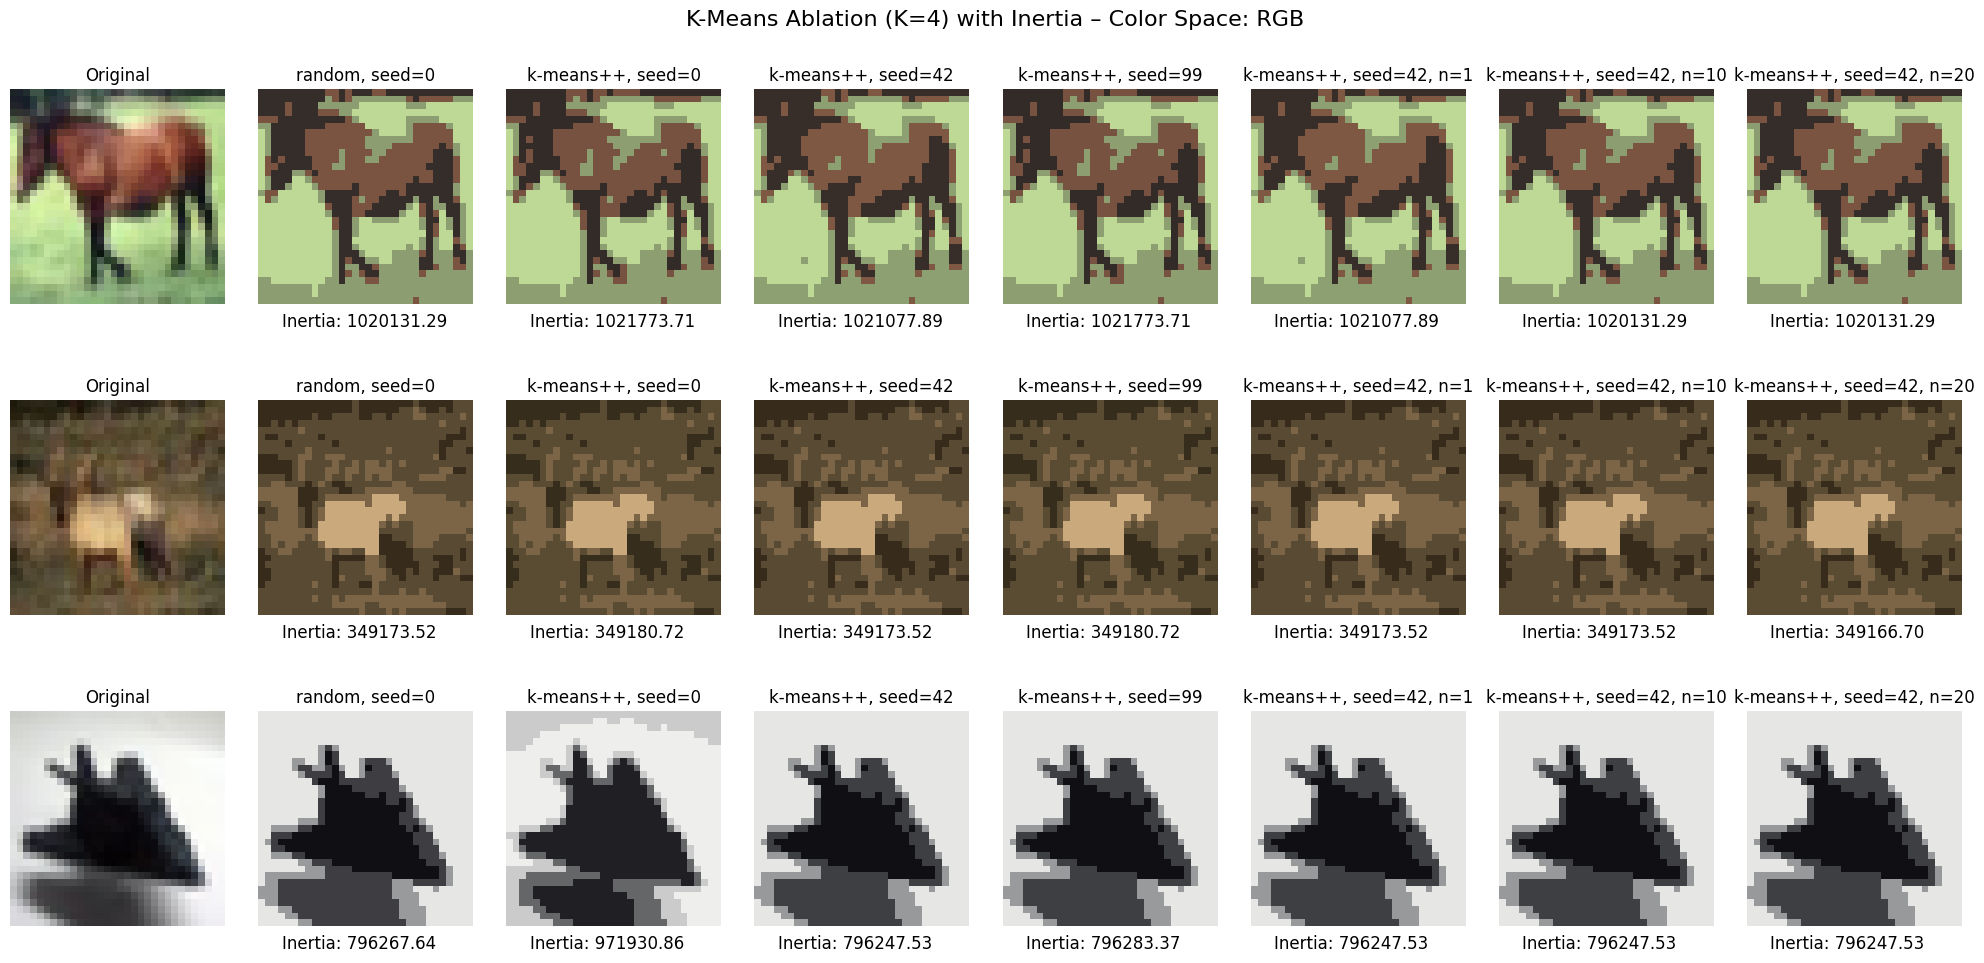

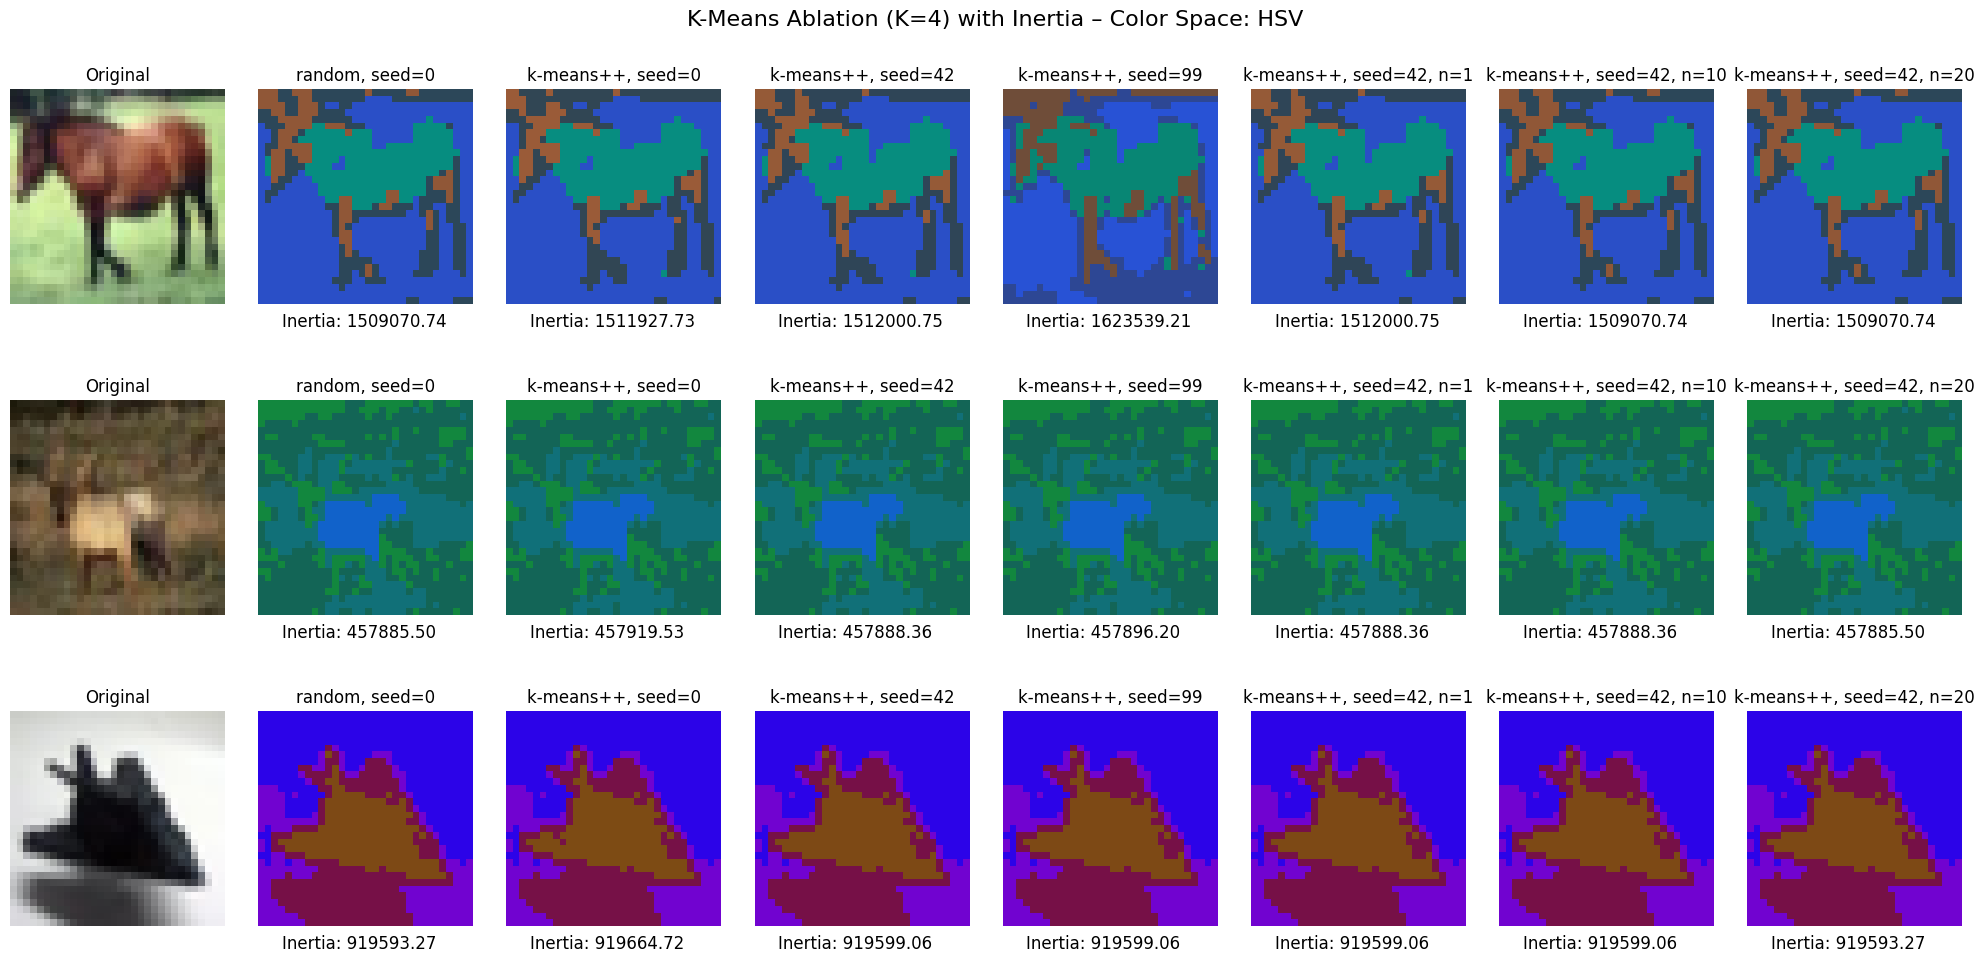

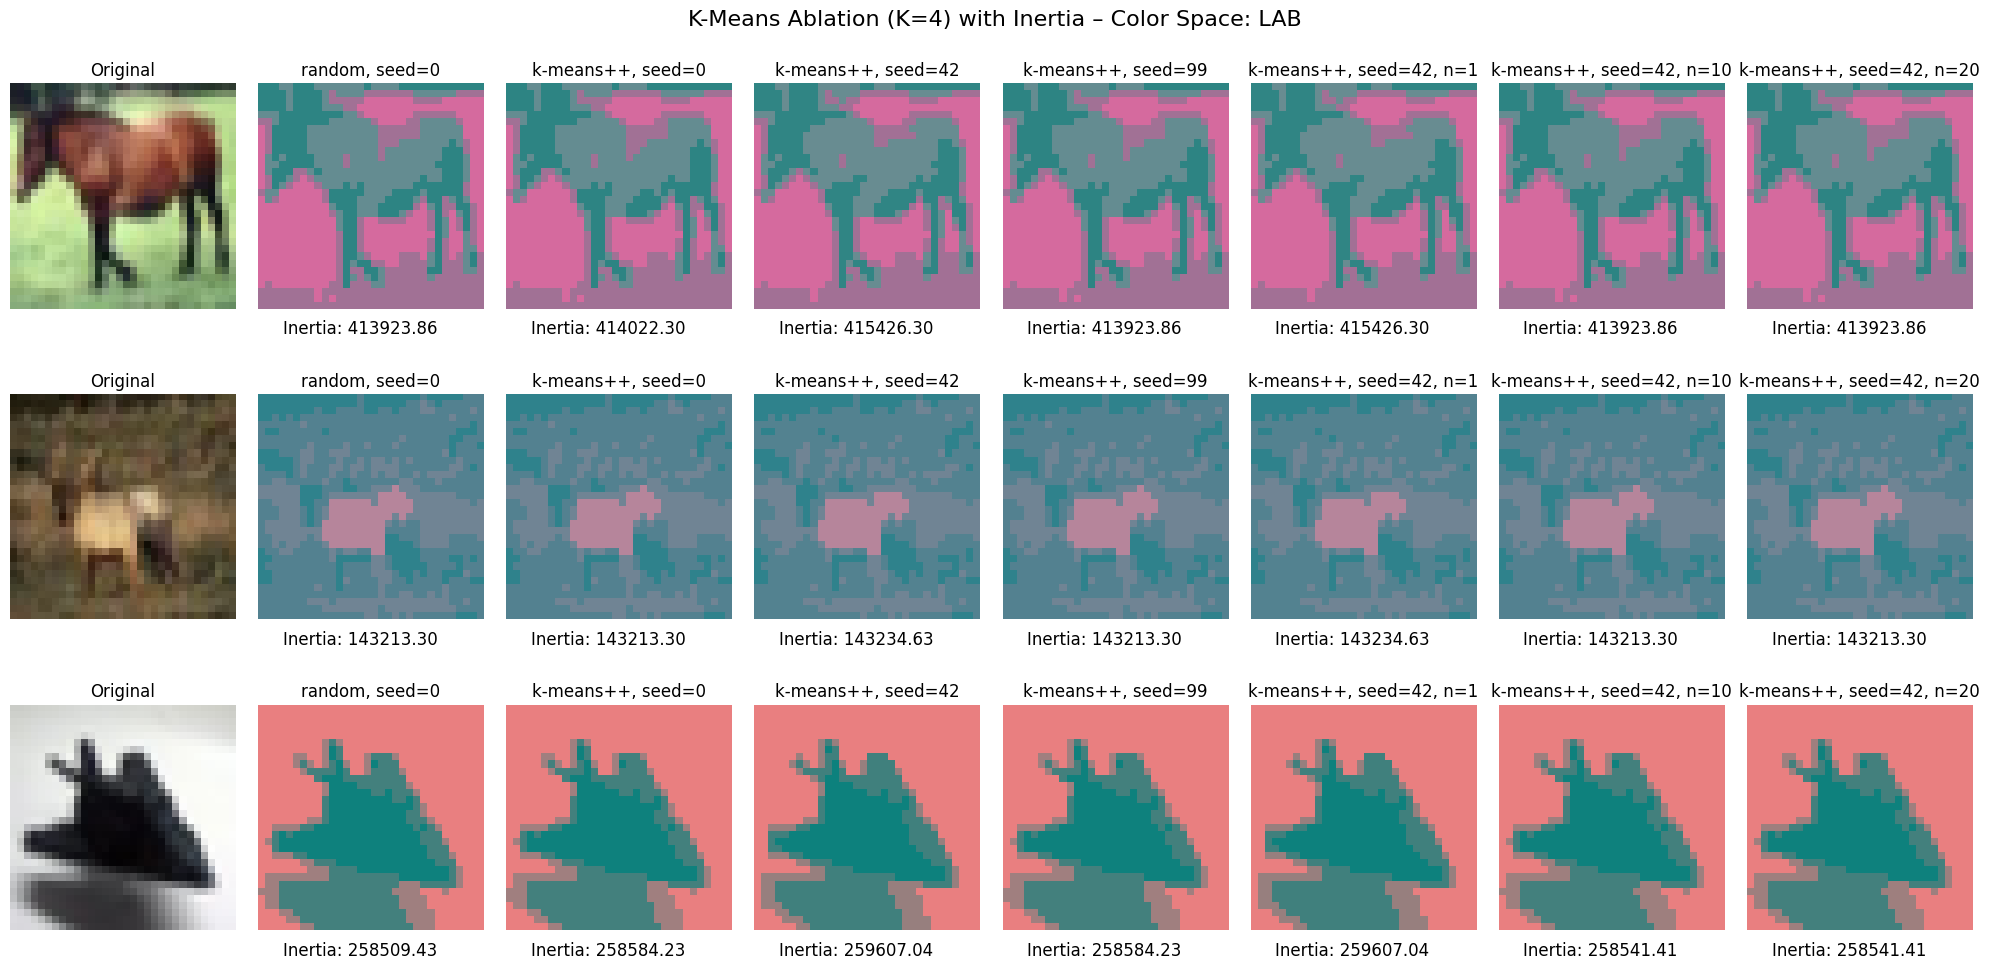

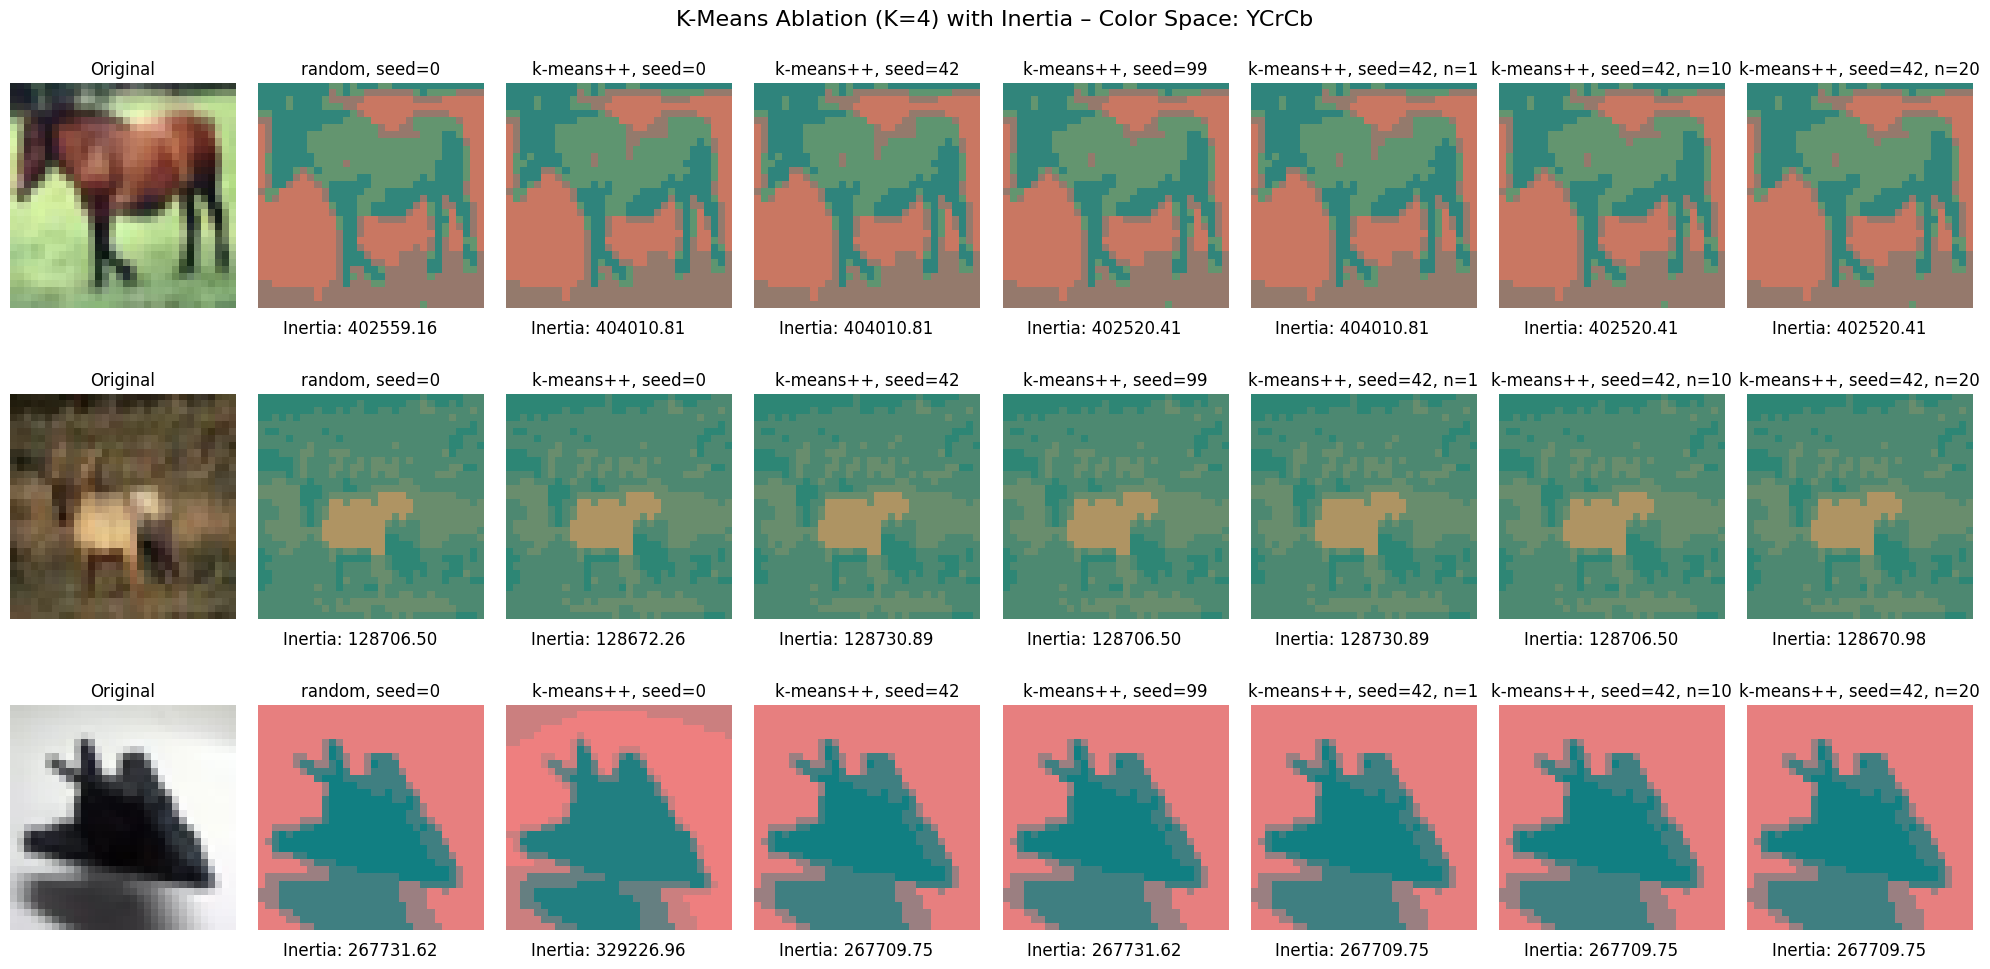

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

# Select one image from each class
selected_indices = [0, 10, 20] # Use image indices for each class (e.g., 0 = airplane, 10 = deer, 20 = horse)
selected_imgs = [bicubic_imgs[i] for i in selected_indices]

# Corresponding flattened vectors
X_rgb_selected = np.array([X_rgb[i] for i in selected_indices])
X_hsv_selected = np.array([X_hsv[i] for i in selected_indices])
X_lab_selected = np.array([X_lab[i] for i in selected_indices])
X_yCrCb_selected = np.array([X_yCrCb[i] for i in selected_indices])

# Define ablation configs
configs = [
    {"name": "random, seed=0", "init": "random", "random_state": 0},
    {"name": "k-means++, seed=0", "init": "k-means++", "random_state": 0},
    {"name": "k-means++, seed=42", "init": "k-means++", "random_state": 42},
    {"name": "k-means++, seed=99", "init": "k-means++", "random_state": 99},
    {"name": "k-means++, seed=42, n=1", "init": "k-means++", "random_state": 42, "n_init": 1},
    {"name": "k-means++, seed=42, n=10", "init": "k-means++", "random_state": 42, "n_init": 10},
    {"name": "k-means++, seed=42, n=20", "init": "k-means++", "random_state": 42, "n_init": 20},
]

# Store all color space versions
all_spaces = {
    "RGB": (X_rgb_selected, selected_imgs),
    "HSV": (X_hsv_selected, selected_imgs),
    "LAB": (X_lab_selected, selected_imgs),
    "YCrCb": (X_yCrCb_selected, selected_imgs),
}

# Run ablation for each color space
for space_name, (X_sel, original_imgs) in all_spaces.items():
    fig, axs = plt.subplots(3, 8, figsize=(20, 10))
    fig.suptitle(f"K-Means Ablation (K=4) with Inertia – Color Space: {space_name}", fontsize = 16)

    for row in range(3):
        axs[row, 0].imshow(original_imgs[row])
        axs[row, 0].set_title("Original", fontsize = 12)
        axs[row, 0].axis("off")

        pixels = X_sel[row].reshape(-1, 3)

        for col, cfg in enumerate(configs):
            kmeans = KMeans(
                n_clusters=4,
                init=cfg["init"],
                random_state=cfg["random_state"],
                n_init = cfg.get("n_init", 'auto')
            )
            labels = kmeans.fit_predict(pixels)
            inertia = kmeans.inertia_
            clustered = kmeans.cluster_centers_[labels].reshape(32, 32, 3).astype(np.uint8)

            axs[row, col + 1].imshow(clustered)
            axs[row, col + 1].set_title(cfg["name"], fontsize = 12)
            axs[row, col + 1].text(3, 35, f"Inertia: {inertia:.2f}", fontsize = 12)
            axs[row, col + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


Color Space: RGB → Elbow at K = 7
Color Space: HSV → Elbow at K = 6
Color Space: LAB → Elbow at K = 4
Color Space: YCrCb → Elbow at K = None


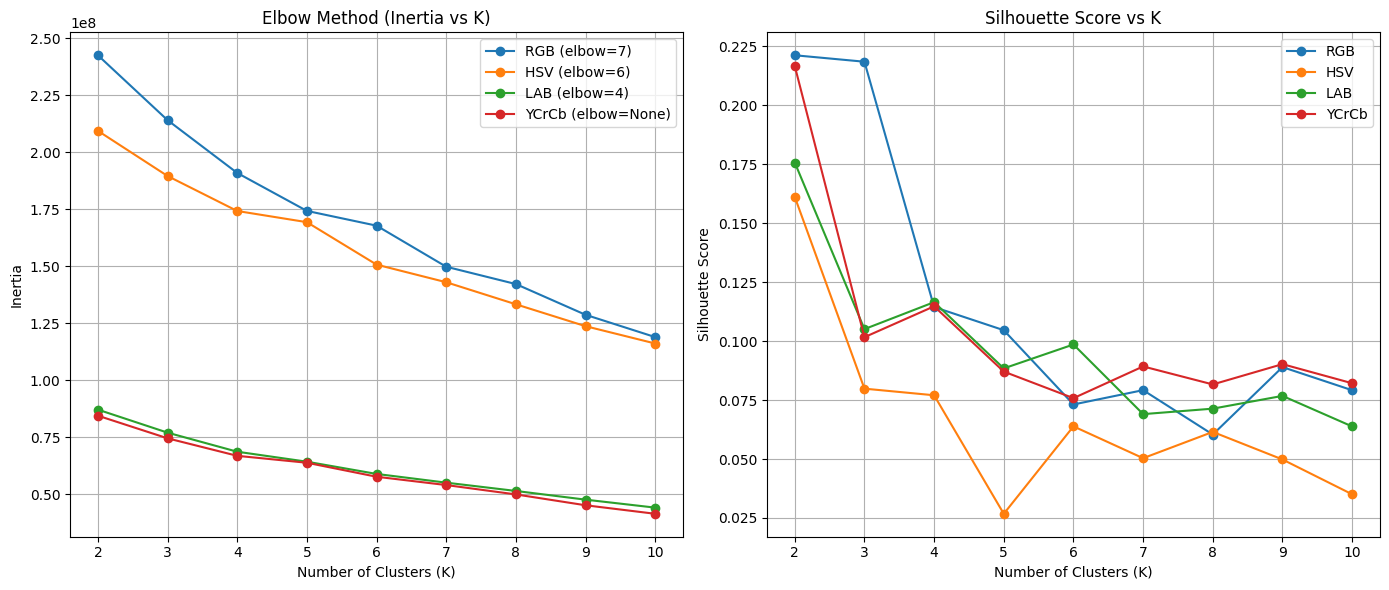

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Assume X_rgb, X_hsv, X_lab, X_yCrCb defined
all_spaces = {
    "RGB": X_rgb,
    "HSV": X_hsv,
    "LAB": X_lab,
    "YCrCb": X_yCrCb,
}

K_range = range(2, 11)  # start from K = 2 for silhouette score bacause atleast 2 clusters needed for comparison
results = {}

for name, X in all_spaces.items():
    inertia_vals = []
    silhouette_vals = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia_vals.append(kmeans.inertia_)
        silhouette_vals.append(silhouette_score(X, labels))

    # Detect elbow using kneed
    knee = KneeLocator(K_range, inertia_vals, curve="convex", direction="decreasing")

    results[name] = {
        "inertia": inertia_vals,
        "silhouette": silhouette_vals,
        "elbow_k": knee.elbow
    }

    print(f"Color Space: {name} → Elbow at K = {knee.elbow}")

# ---------- Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Inertia plot (Elbow method)
for name in results:
    axes[0].plot(K_range, results[name]["inertia"], marker='o', label=f"{name} (elbow={results[name]['elbow_k']})")
axes[0].set_title("Elbow Method (Inertia vs K)")
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)
axes[0].legend()

# Silhouette score plot
for name in results:
    axes[1].plot(K_range, results[name]["silhouette"], marker='o', label=name)
axes[1].set_title("Silhouette Score vs K")
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

## Adding pixel coordinates to colorspace for K-means clustering

## Image is directly changed to different Colorspaces

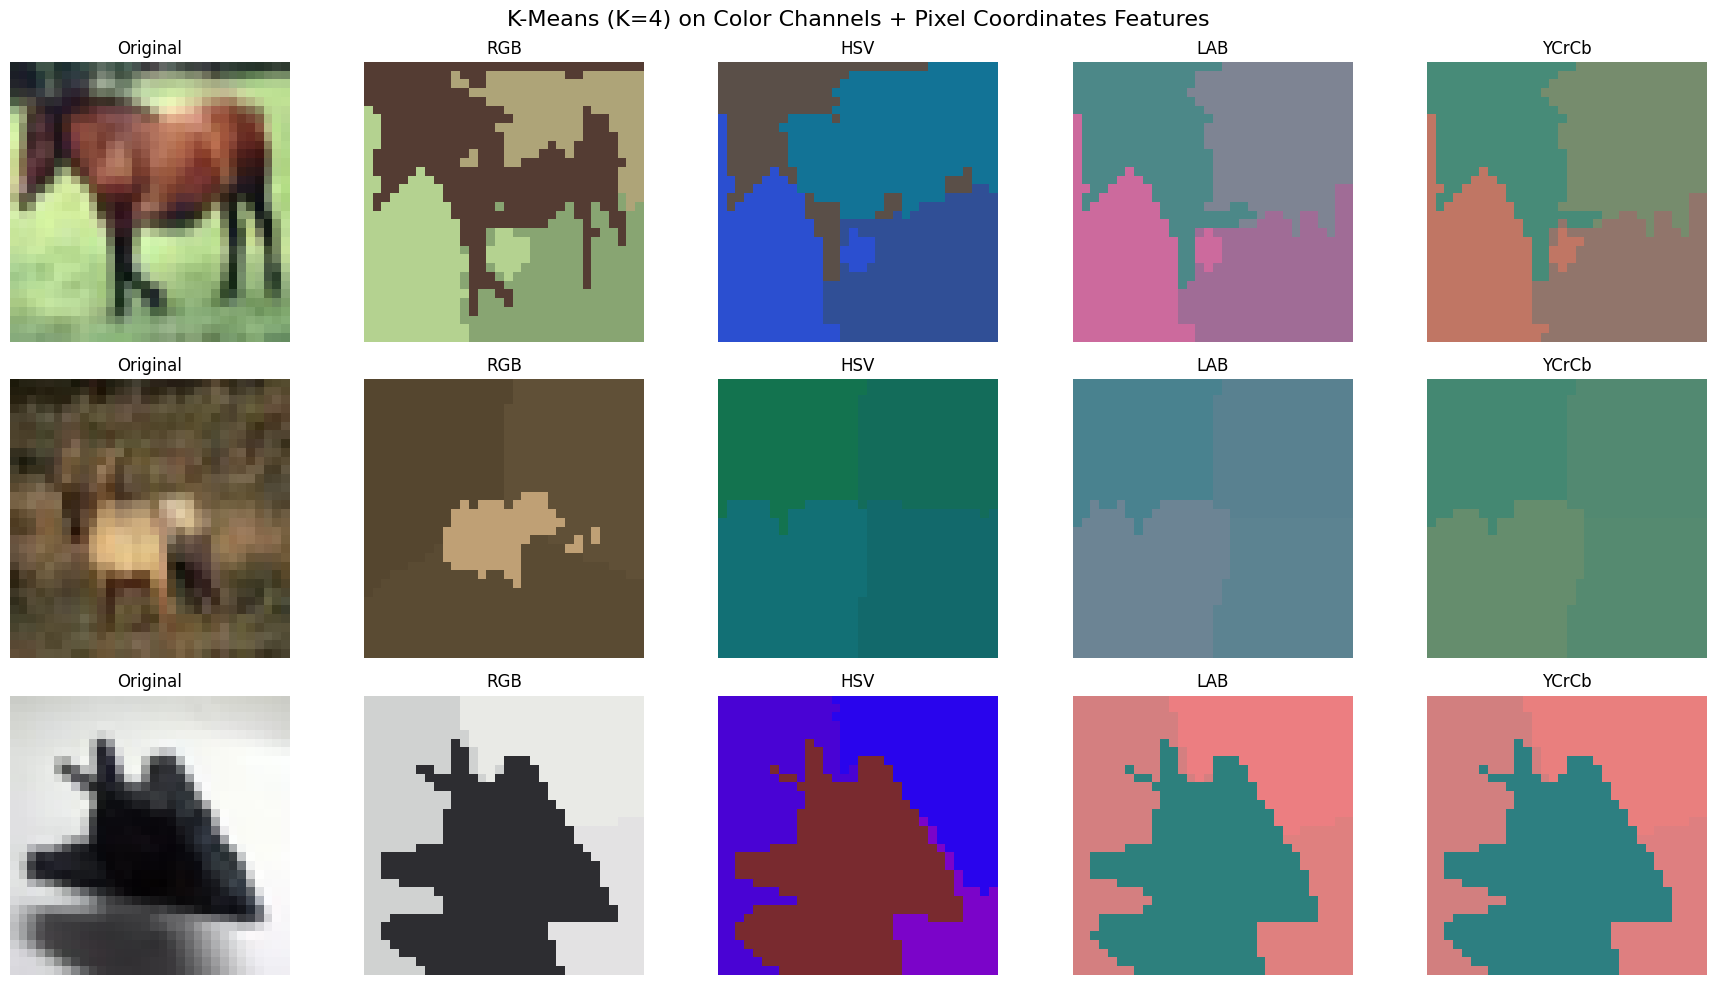

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2

def add_xy_to_color_features(image):
    h, w, c = image.shape
    color = image.reshape(-1, 3).astype(np.float32) / 255.0
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]])  # normalize x, y
    return np.hstack([color, coords])  # shape (H*W, 5)

# Select one image per class
indices = [0, 10, 20]
selected_imgs = [bicubic_imgs[i] for i in indices]

# Prepare plots
fig, axs = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle("K-Means (K=4) on Color Channels + Pixel Coordinates Features", fontsize=16)

# Loop through each image
for row, img in enumerate(selected_imgs):
    axs[row, 0].imshow(img)
    axs[row, 0].set_title("Original")
    axs[row, 0].axis("off")

    # Convert to different color spaces
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    space_dict = {
        "RGB": img,
        "HSV": img_hsv,
        "LAB": img_lab,
        "YCrCb": img_ycrcb
    }

    # Perform clustering in each color space with XY
    for col, (space, img_space) in enumerate(space_dict.items()):
        features = add_xy_to_color_features(img_space)

        kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
        labels = kmeans.fit_predict(features)
        centers = kmeans.cluster_centers_[:, :3]  # only color part

        segmented = centers[labels].reshape(32, 32, 3)
        axs[row, col + 1].imshow((segmented * 255).astype(np.uint8))
        axs[row, col + 1].set_title(space, fontsize = 12)
        axs[row, col + 1].axis("off")

plt.tight_layout()
plt.show()

## Image Pixel Arrays utilized to add co-ordinates and Analyze

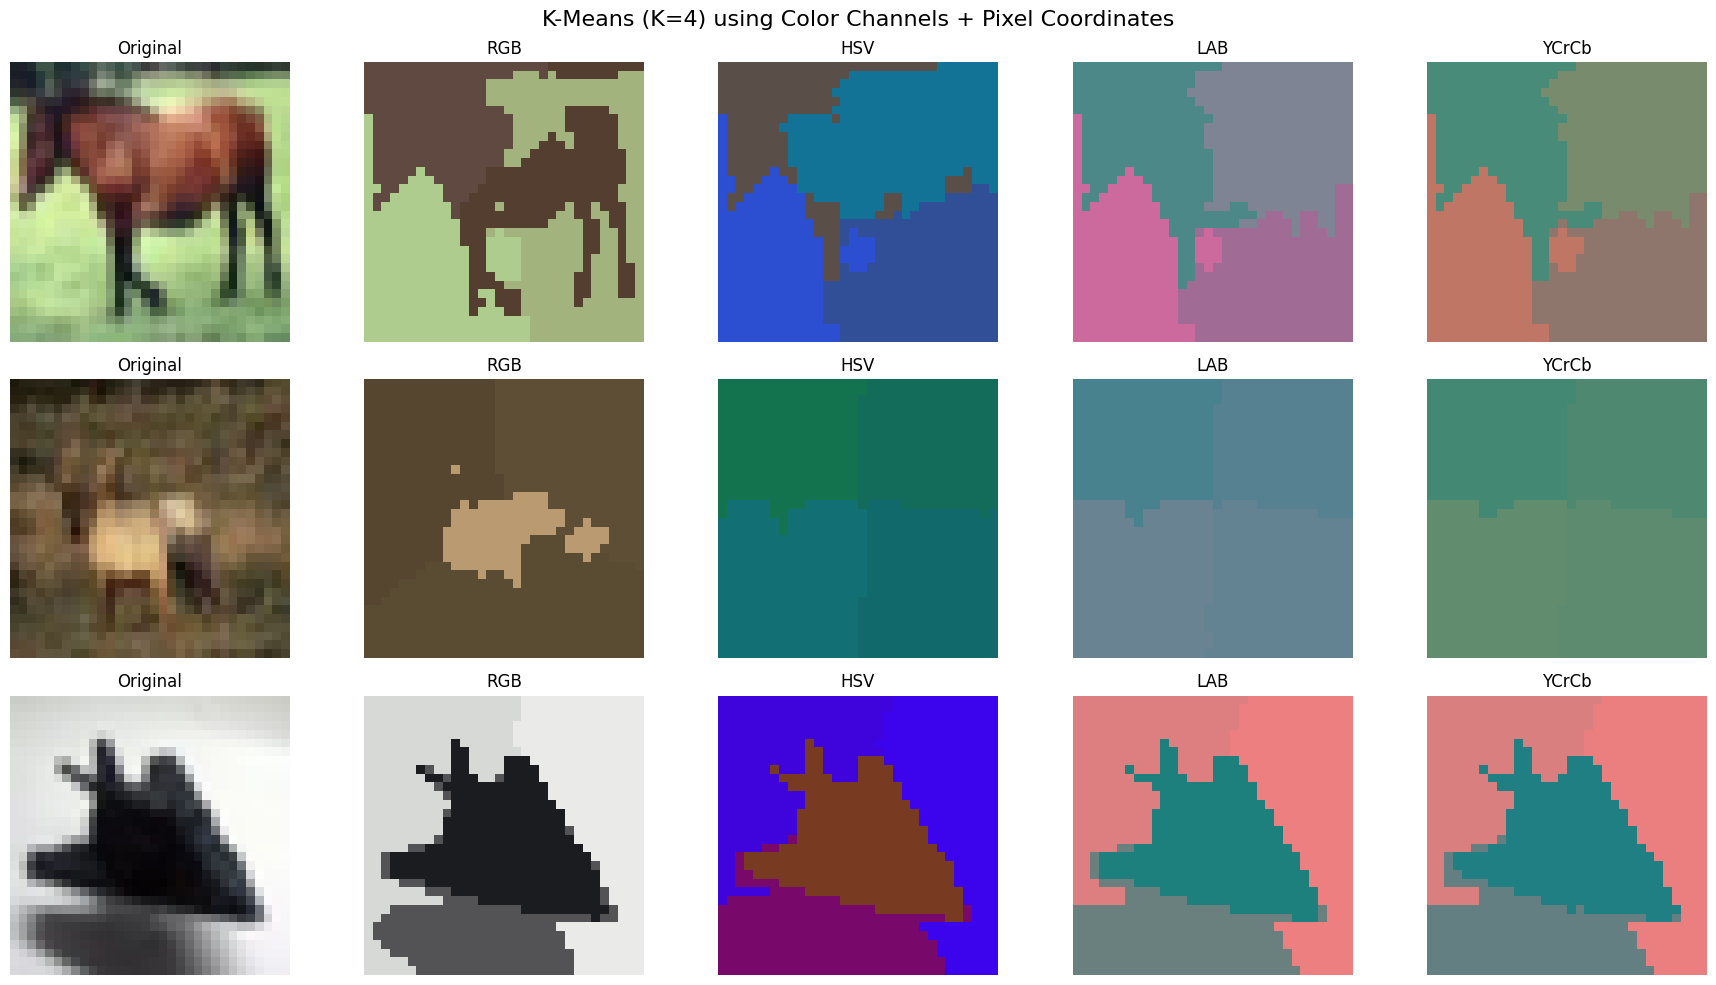

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def add_xy_to_flat_color(flat_color, h = 32, w = 32):
    """
    flat_color: shape (3072,) → flatten of (32, 32, 3)
    returns: (1024, 5) → [R,G,B,x,y] or [H,S,V,x,y], etc.
    """
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0 # Normalizing Color Channel values 
    pixels = color.reshape(-1, 3) # Shape (1024, 3)
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2) # Shape (1024, 2)
    coords = coords / np.array([[h, w]]) # Normalizing Pixel Co-ordinate values 
    return np.hstack([pixels, coords]) # Shape (1024, 5)

# Select indices for 3 representative images
indices = [0, 10, 20] # Use image indices for each class (e.g., 0 = airplane, 10 = deer, 20 = horse)

color_spaces = {
    "RGB": X_rgb,
    "HSV": X_hsv,
    "LAB": X_lab,
    "YCrCb": X_yCrCb
}

# Corresponding original images for plotting
selected_imgs = [bicubic_imgs[i] for i in indices]

# Create plot
fig, axs = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle("K-Means (K=4) using Color Channels + Pixel Coordinates", fontsize = 16)

for row, idx in enumerate(indices):
    axs[row, 0].imshow(selected_imgs[row])
    axs[row, 0].set_title("Original")
    axs[row, 0].axis("off")

    for col, (space_name, X_space) in enumerate(color_spaces.items()):
        flat_color = X_space[idx]  # shape: (3072,)
        features = add_xy_to_flat_color(flat_color)  # shape: (1024, 5)

        kmeans = KMeans(n_clusters = 4, n_init = 'auto', random_state = 42)
        labels = kmeans.fit_predict(features)
        centers = kmeans.cluster_centers_[:, :3]  # only color part utilized for re-assignment
        segmented = centers[labels].reshape(32, 32, 3)

        axs[row, col + 1].imshow((segmented * 255).astype(np.uint8))
        axs[row, col + 1].set_title(space_name, fontsize = 12)
        axs[row, col + 1].axis("off")

plt.tight_layout()
plt.show()

## Weighted Color Channel - Pixel Co-ordinates Analysis

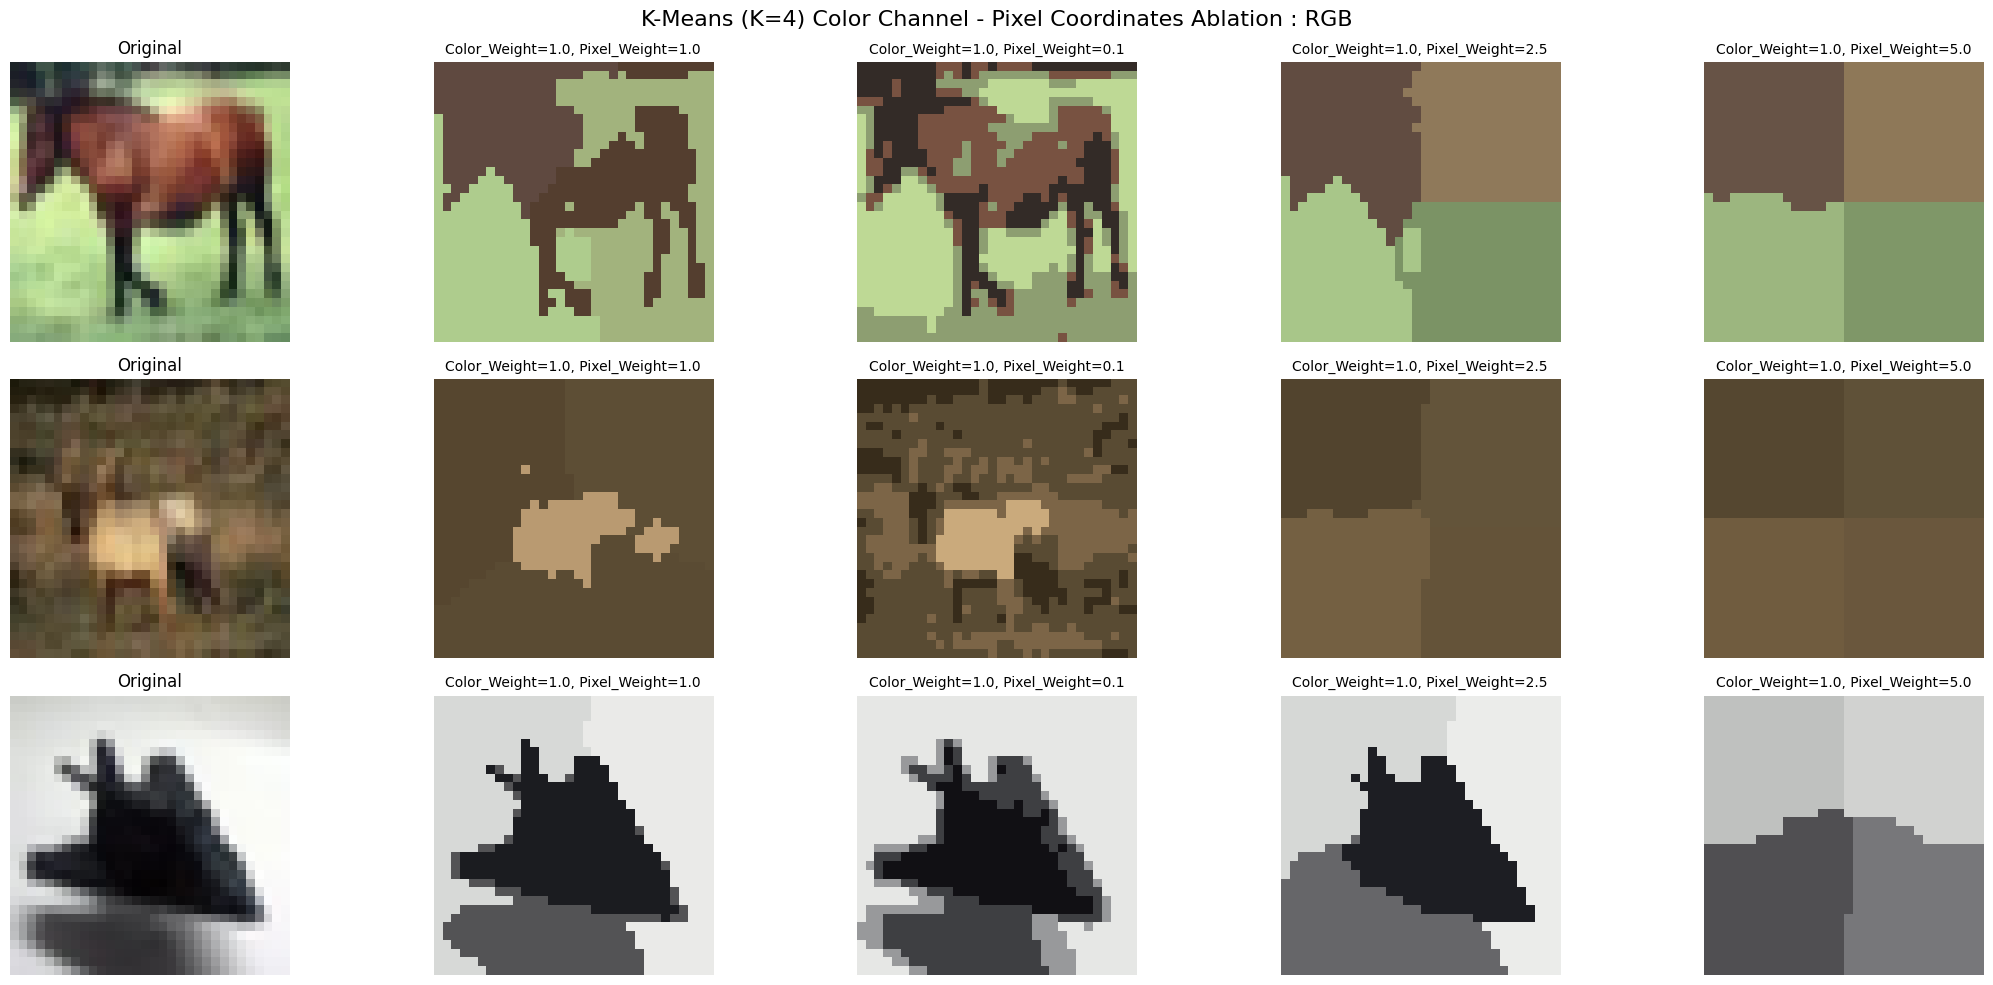

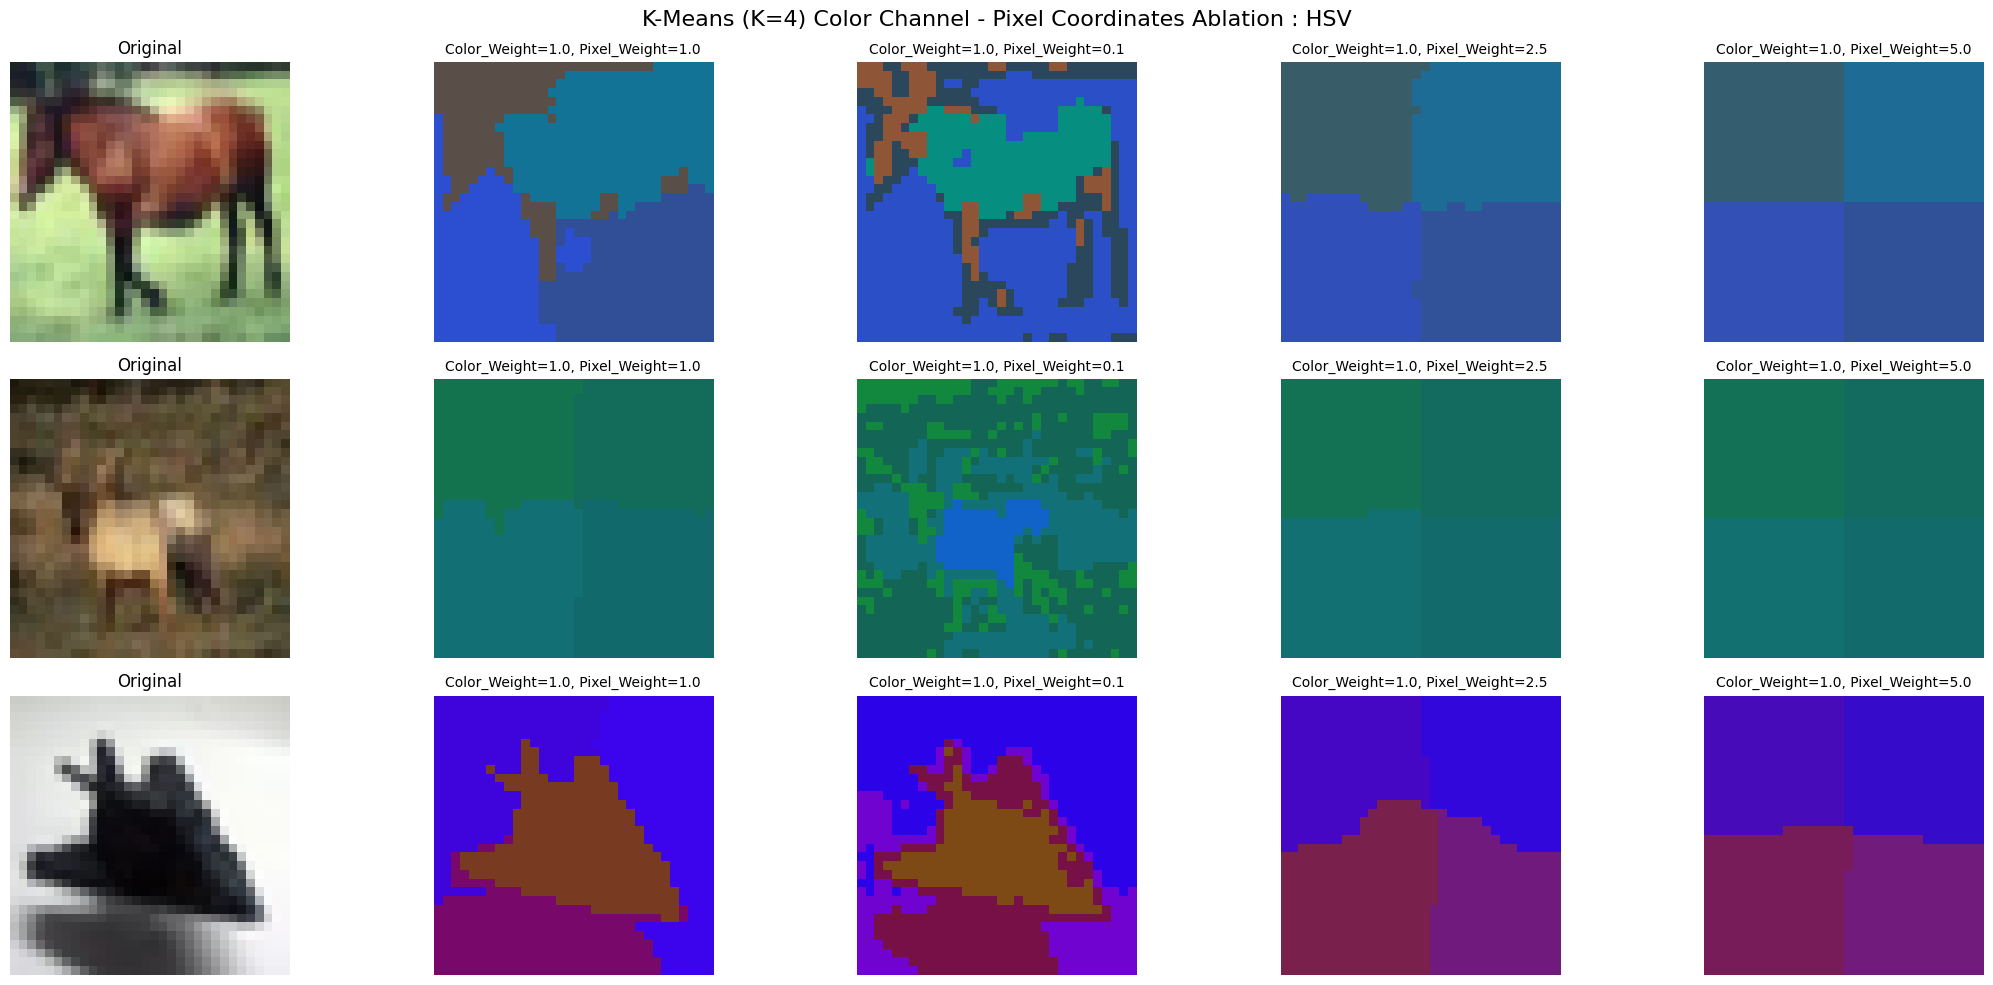

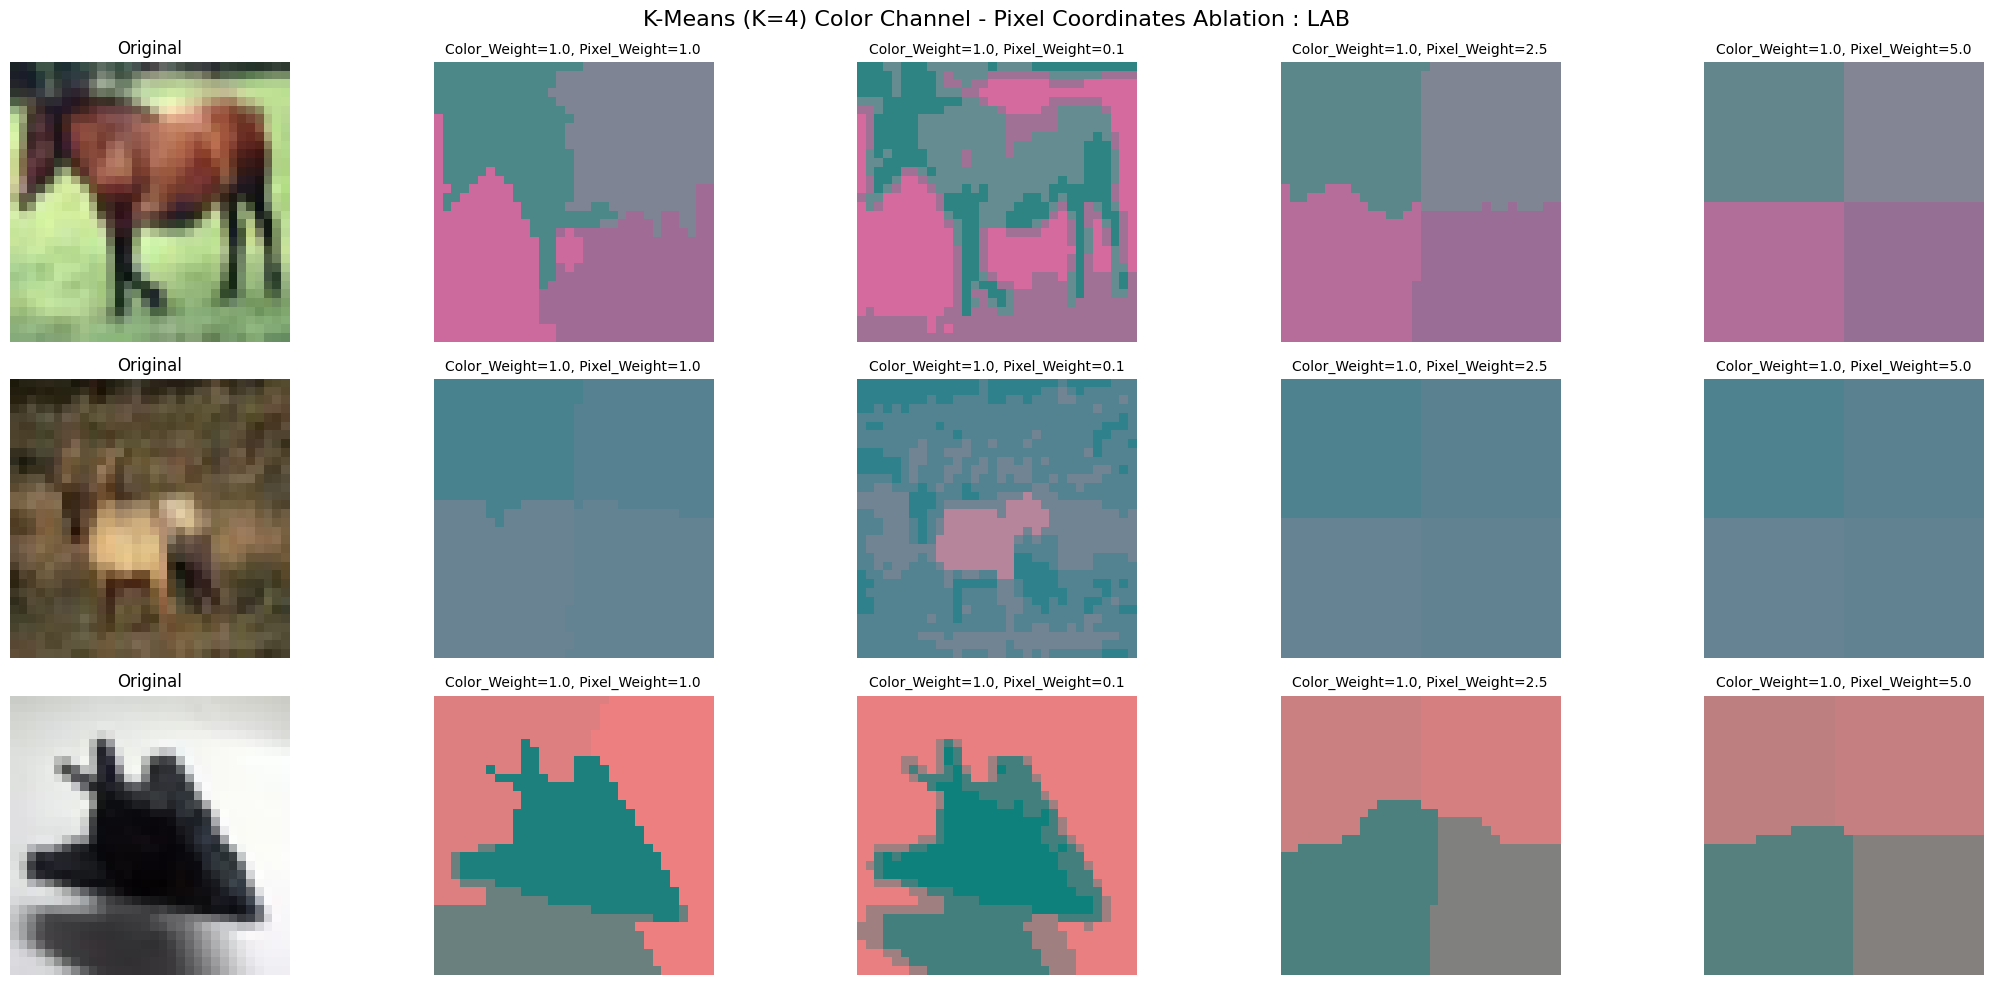

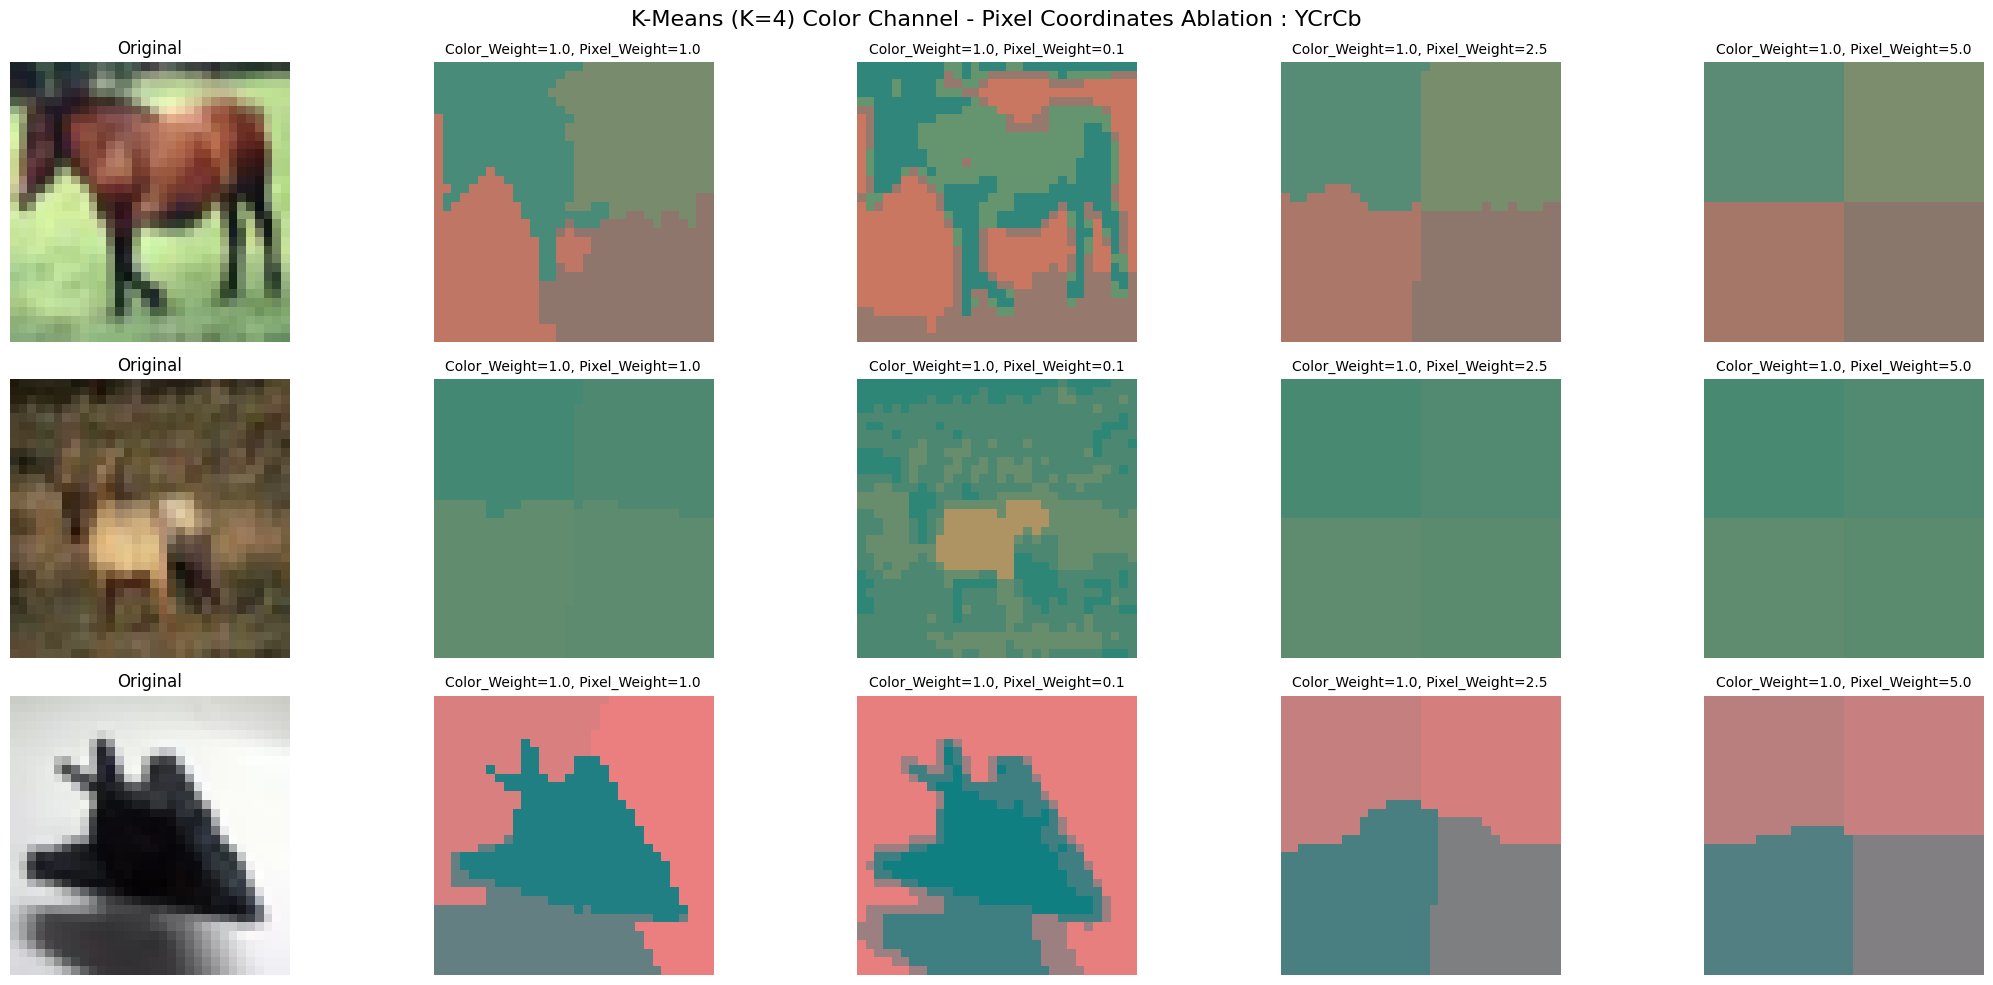

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def create_weighted_features(flat_color, color_weight=1.0, pos_weight=1.0, h=32, w=32):
    """
    Creates a (1024, 5) feature matrix: [color * color_weight | position * pos_weight]
    """
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0 # normalize to [0,1]
    color = color.reshape(-1, 3) * color_weight

    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]])  # normalize to [0,1]
    coords = coords * pos_weight

    return np.hstack([color, coords])  # shape: (1024, 5)

# Select 3 representative images
indices = [0, 10, 20]
selected_imgs = [bicubic_imgs[i] for i in indices]

# Stored arrays
color_spaces = {
    "RGB": X_rgb,
    "HSV": X_hsv,
    "LAB": X_lab,
    "YCrCb": X_yCrCb
}

# Define ablation settings (tuples of (color_weight, pos_weight))
ablations = [
    (1.0, 1.0),   # balanced [Default]
    (1.0, 0.1),   # strong color, weak spatial 
    (1.0, 2.5),   # medium spatial emphasis
    (1.0, 5.0),   # strong spatial constraint
]

# Plotting
for color_space_name, X_space in color_spaces.items():
    fig, axs = plt.subplots(3, 5, figsize=(22, 10))
    fig.suptitle(f"K-Means (K=4) Color Channel - Pixel Coordinates Ablation : {color_space_name}", fontsize=16)

    for row, idx in enumerate(indices):
        axs[row, 0].imshow(selected_imgs[row])
        axs[row, 0].set_title("Original")
        axs[row, 0].axis("off")

        flat_color = X_space[idx]  # shape: (3072,)

        for col, (cw, pw) in enumerate(ablations):
            features = create_weighted_features(flat_color, color_weight=cw, pos_weight=pw)

            kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
            labels = kmeans.fit_predict(features)
            centers = kmeans.cluster_centers_[:, :3]
            segmented = centers[labels].reshape(32, 32, 3)

            axs[row, col + 1].imshow((segmented * 255).astype(np.uint8))
            axs[row, col + 1].set_title(f"Color_Weight={cw}, Pixel_Weight={pw}", fontsize=10)
            axs[row, col + 1].axis("off")

    plt.tight_layout()
    plt.show()

## Adding Texture Features to existing Color Channels - Pixel Coordinates system

## All Textural Features Added Together

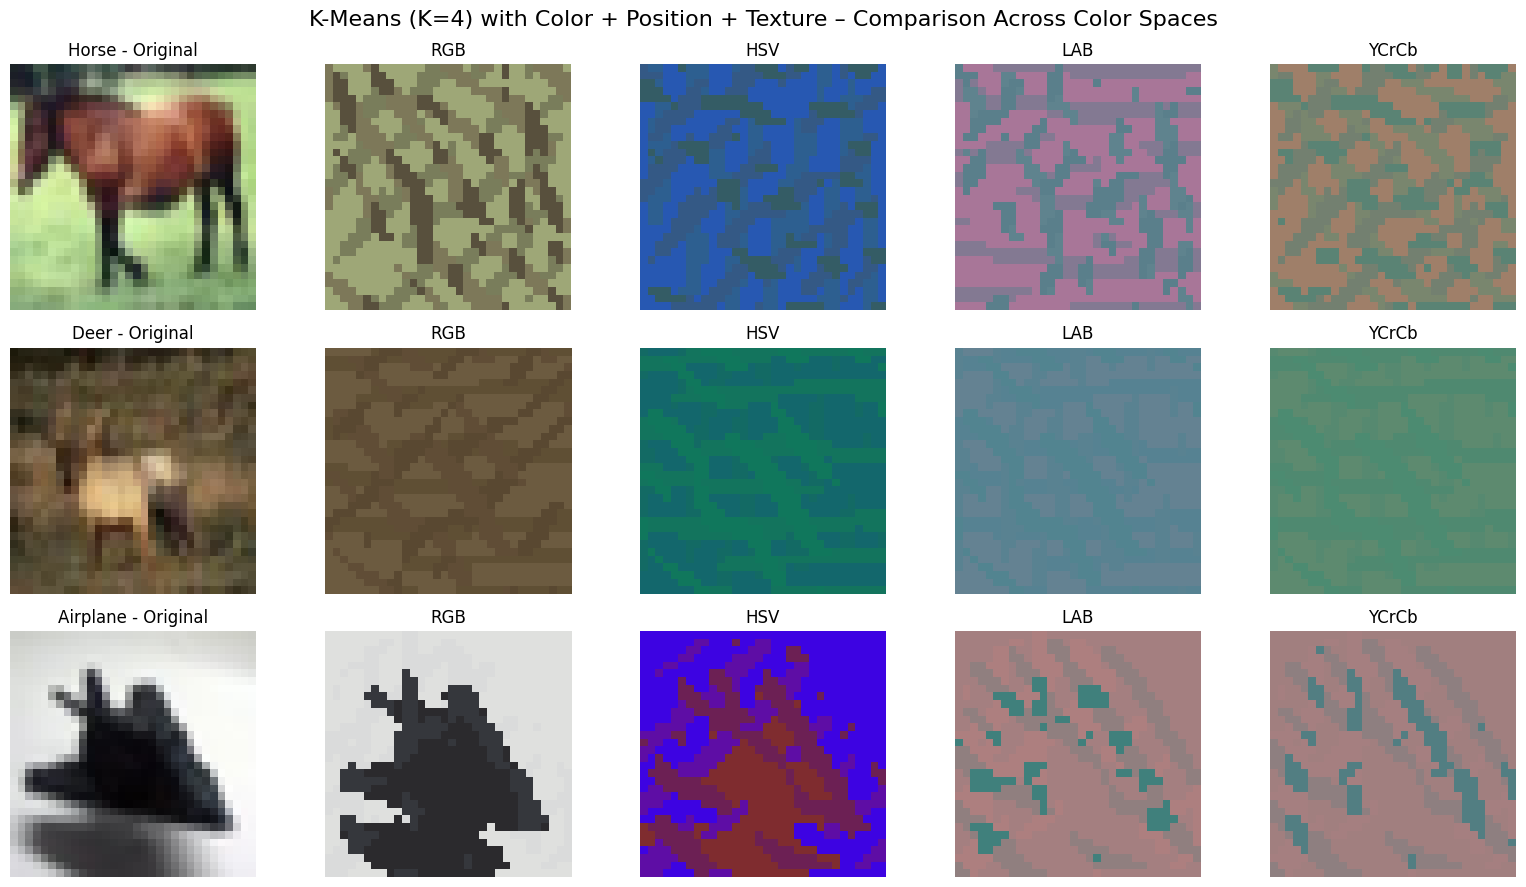

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from skimage.filters import gabor
from skimage.feature import local_binary_pattern

# ---- TEXTURE FEATURE FUNCTIONS ----
def compute_sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    return (edge_mag - edge_mag.min()) / (edge_mag.ptp() + 1e-5)

def compute_laplacian(gray):
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    return (lap - lap.min()) / (lap.ptp() + 1e-5)

def compute_lbp(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    return lbp / lbp.max()

def compute_gabor_features(gray, frequencies=[0.2], orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gabor_feats = []
    for theta in orientations:
        filt_real, _ = gabor(gray, frequency=frequencies[0], theta=theta)
        norm = (filt_real - filt_real.min()) / (filt_real.ptp() + 1e-5)
        gabor_feats.append(norm)
    return np.stack(gabor_feats, axis=-1)

def extract_texture_features(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    sobel = compute_sobel_magnitude(gray)
    lap = compute_laplacian(gray)
    lbp = compute_lbp(gray)
    gabor_feats = compute_gabor_features(gray)

    h, w = gray.shape
    features = [
        sobel.reshape(-1, 1),
        lap.reshape(-1, 1),
        lbp.reshape(-1, 1),
        gabor_feats.reshape(h * w, -1)
    ]
    return np.hstack(features)

# ---- COMBINED FEATURE FUNCTION ----
def get_combined_features(img, flat_color, pos_weight=0.1, color_weight=1.0):
    h, w = 32, 32
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0
    color = color.reshape(-1, 3) * color_weight

    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]]) * pos_weight

    texture = extract_texture_features(img)
    return np.hstack([color, coords, texture])

# ---- MAIN VISUALIZATION ----
def run_kmeans_side_by_side(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb):
    indices = [0, 10, 20]
    image_names = ["Horse", "Deer", "Airplane"]
    color_spaces = {
        "RGB": X_rgb,
        "HSV": X_hsv,
        "LAB": X_lab,
        "YCrCb": X_yCrCb
    }

    fig, axs = plt.subplots(len(indices), len(color_spaces) + 1, figsize=(16, 9))
    fig.suptitle("K-Means (K=4) with Color + Position + Texture – Comparison Across Color Spaces", fontsize=16)

    for row, idx in enumerate(indices):
        img_rgb = bicubic_imgs[idx]
        axs[row, 0].imshow(img_rgb)
        axs[row, 0].set_title(f"{image_names[row]} - Original")
        axs[row, 0].axis("off")

        for col, (space_name, X_space) in enumerate(color_spaces.items(), start=1):
            flat_color = X_space[idx]
            features = get_combined_features(img_rgb, flat_color, pos_weight=0.1, color_weight=1.0)

            kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
            labels = kmeans.fit_predict(features)
            centers = kmeans.cluster_centers_[:, :3]
            segmented = centers[labels].reshape(32, 32, 3)

            axs[row, col].imshow((segmented * 255).astype(np.uint8))
            axs[row, col].set_title(space_name)
            axs[row, col].axis("off")

    plt.tight_layout()
    plt.show()

run_kmeans_side_by_side(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from skimage.filters import gabor
from skimage.feature import local_binary_pattern

# --- Individual Texture Feature Functions ---
def compute_sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    return (edge_mag - edge_mag.min()) / (edge_mag.ptp() + 1e-5)

def compute_laplacian(gray):
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    return (lap - lap.min()) / (lap.ptp() + 1e-5)

def compute_lbp(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    return lbp / lbp.max()

def compute_gabor(gray, theta):
    filt_real, _ = gabor(gray, frequency=0.2, theta=theta)
    return (filt_real - filt_real.min()) / (filt_real.ptp() + 1e-5)

# --- K-Means using one texture feature with weights ---
def run_single_texture_feature_weighted(img_rgb, flat_color, texture_name, pos_weight=1.0, color_weight=1.0):
    h, w = 32, 32
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Color and Position Features
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0
    color = color.reshape(-1, 3) * color_weight
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]]) * pos_weight

    # Texture Feature Selection
    if texture_name == 'sobel':
        texture = compute_sobel_magnitude(gray).reshape(-1, 1)
    elif texture_name == 'laplacian':
        texture = compute_laplacian(gray).reshape(-1, 1)
    elif texture_name == 'lbp':
        texture = compute_lbp(gray).reshape(-1, 1)
    elif texture_name == 'gabor0':
        texture = compute_gabor(gray, theta=0).reshape(-1, 1)
    elif texture_name == 'gabor45':
        texture = compute_gabor(gray, theta=np.pi/4).reshape(-1, 1)
    elif texture_name == 'gabor90':
        texture = compute_gabor(gray, theta=np.pi/2).reshape(-1, 1)
    elif texture_name == 'gabor135':
        texture = compute_gabor(gray, theta=3*np.pi/4).reshape(-1, 1)
    else:
        texture = np.zeros((h*w, 1))

    # Combine Features and Apply KMeans
    features = np.hstack([color, coords, texture])
    kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
    labels = kmeans.fit_predict(features)
    centers = kmeans.cluster_centers_[:, :3]
    segmented = centers[labels].reshape(32, 32, 3)

    return segmented

## Adding one texture feature at a time

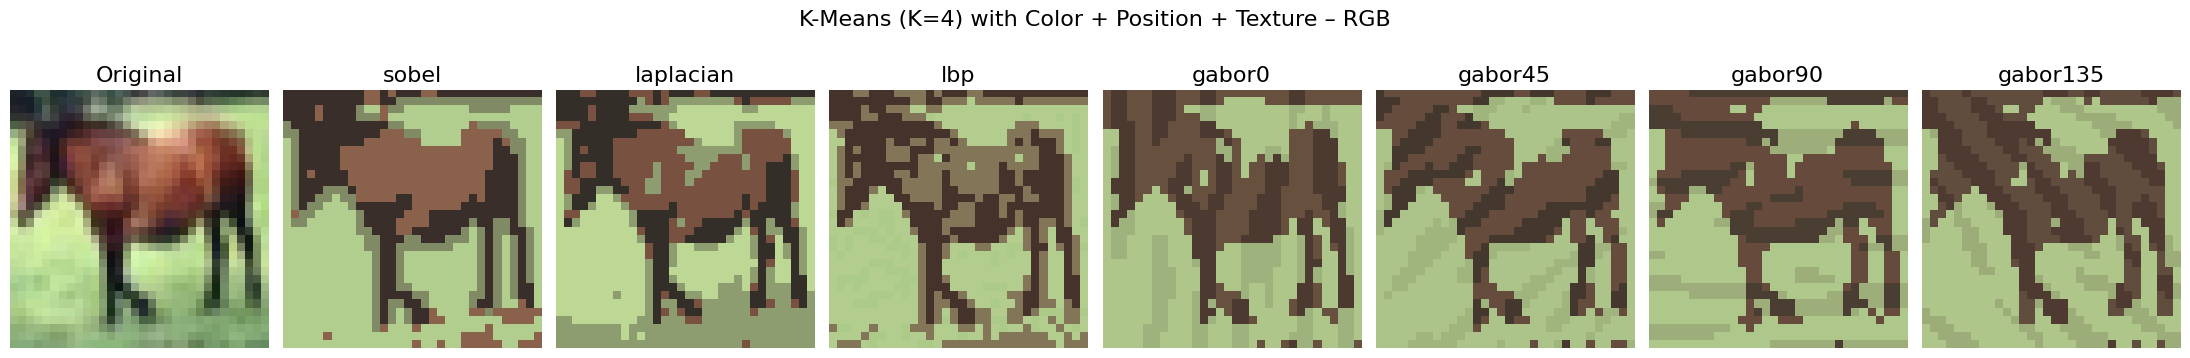

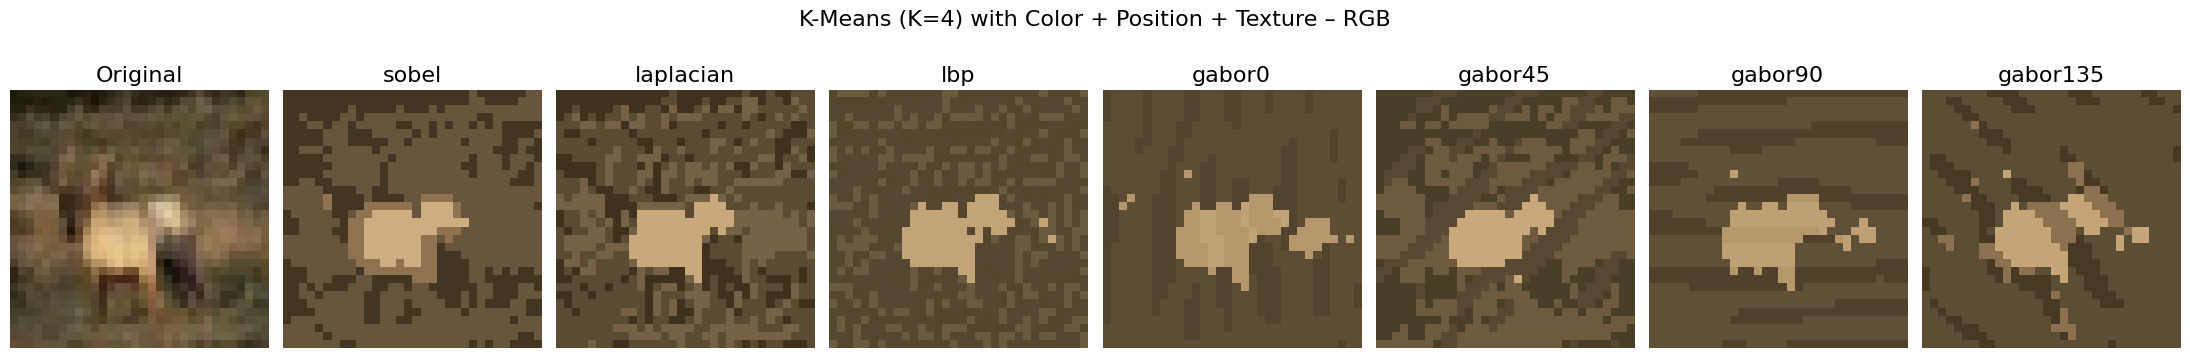

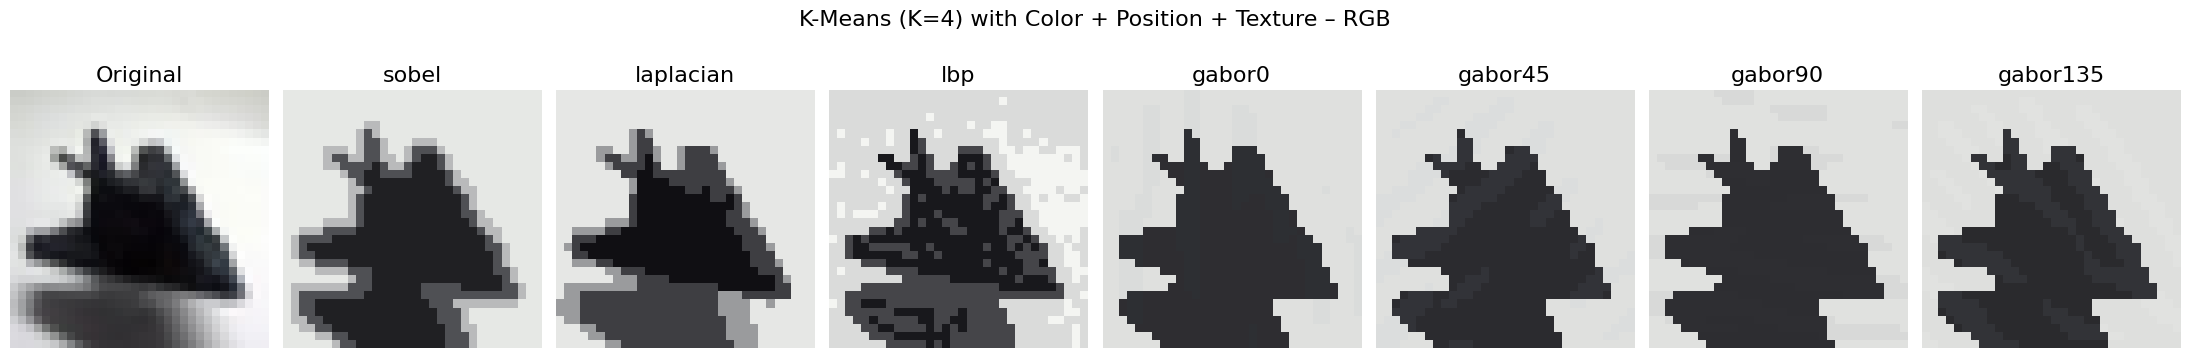

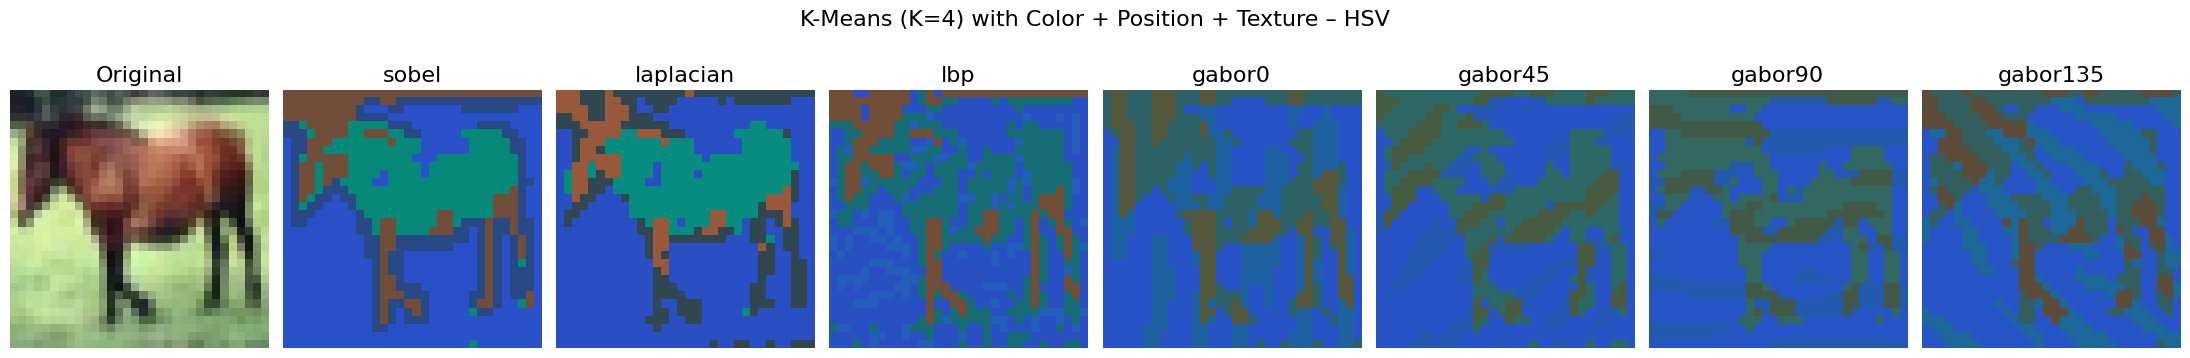

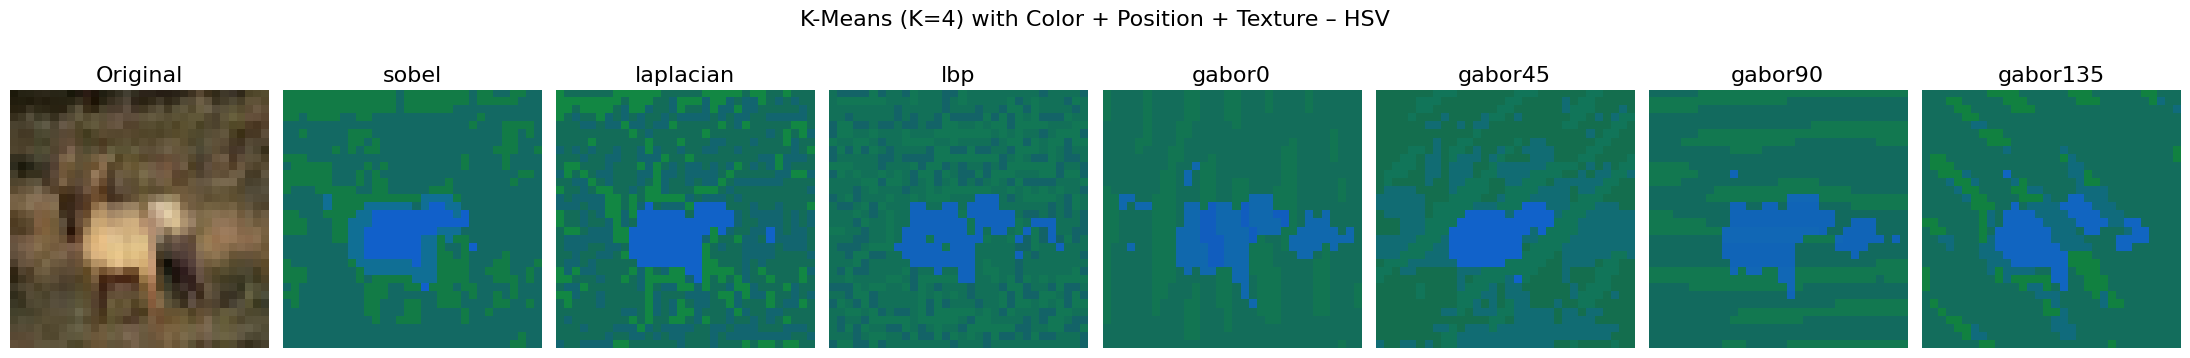

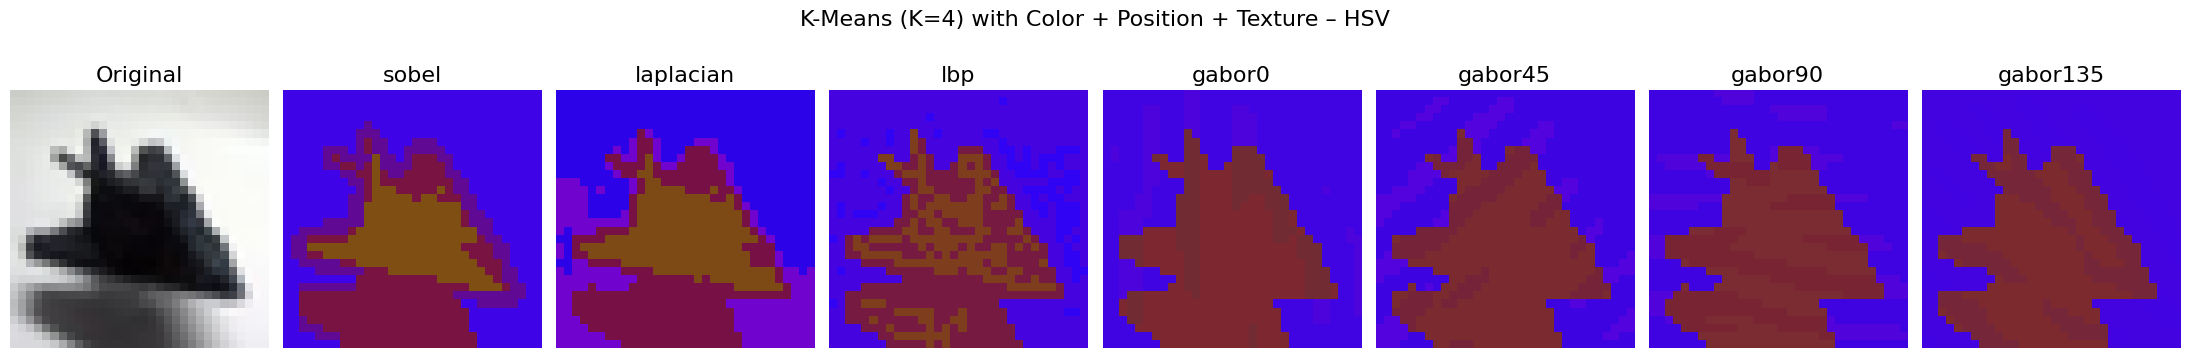

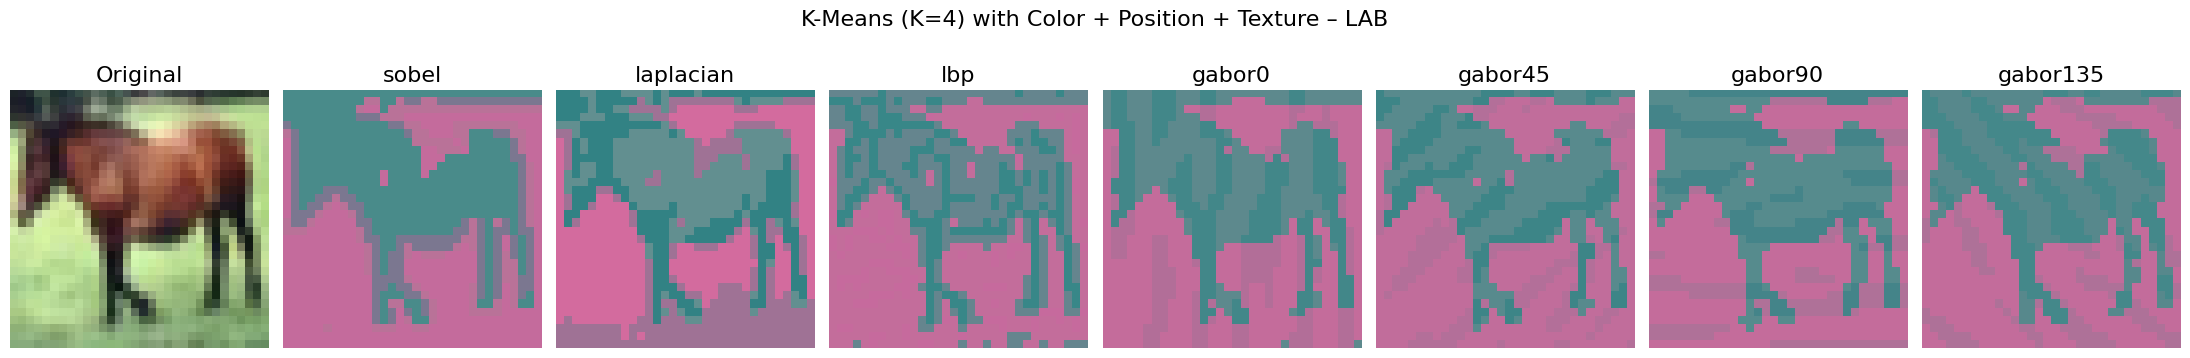

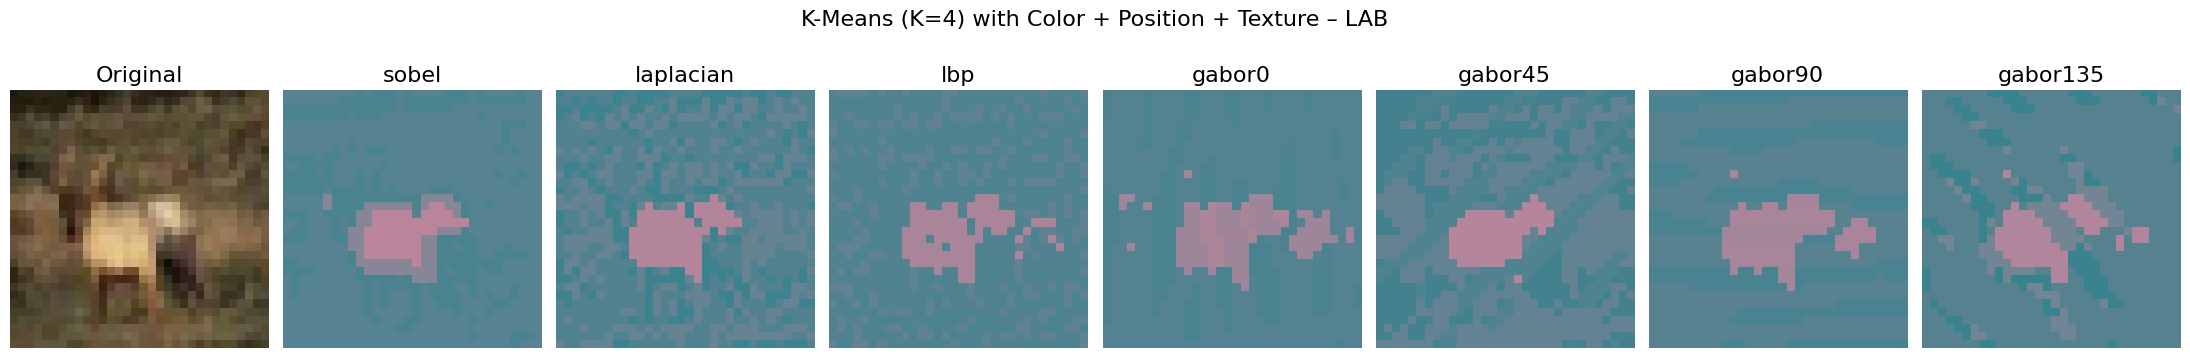

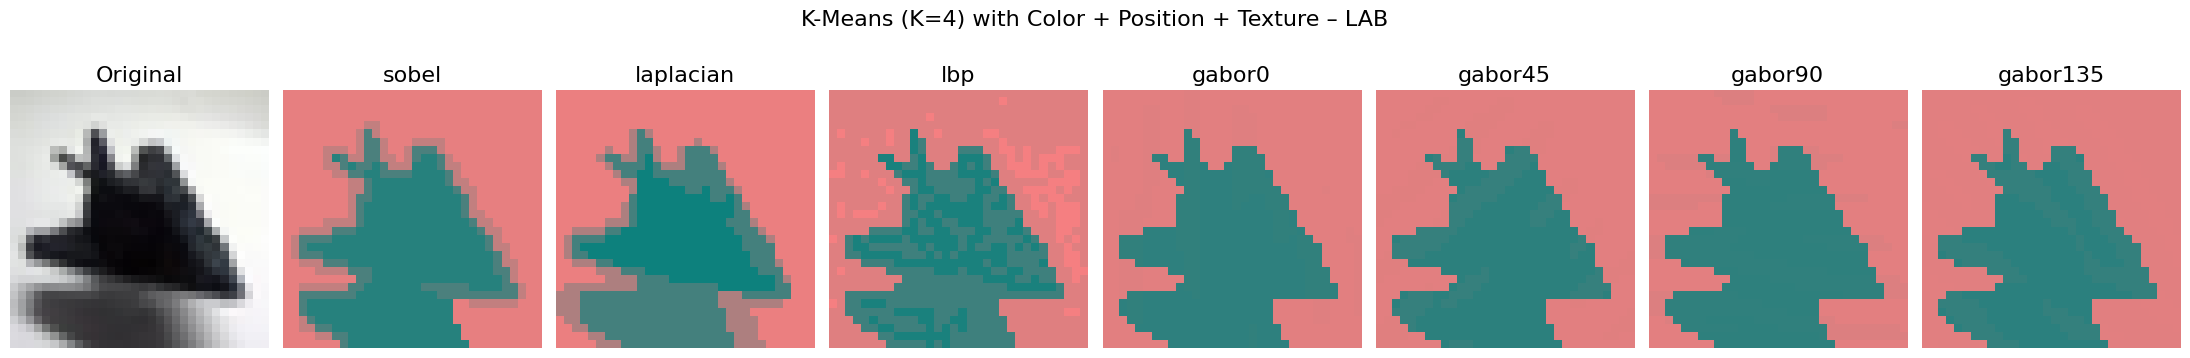

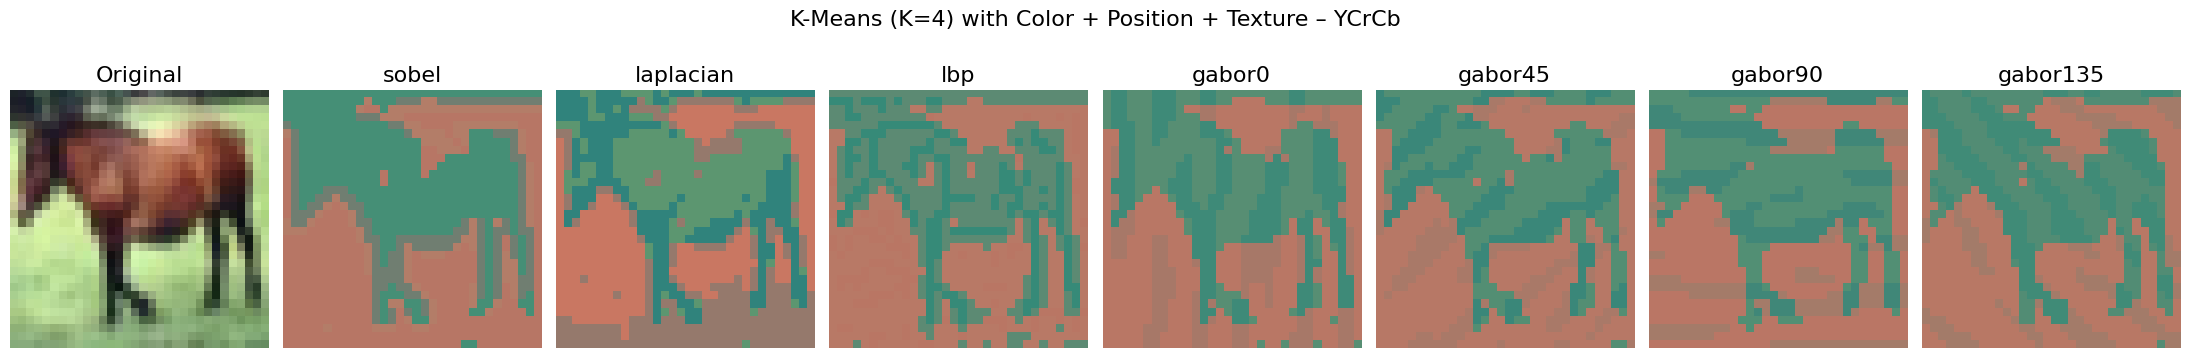

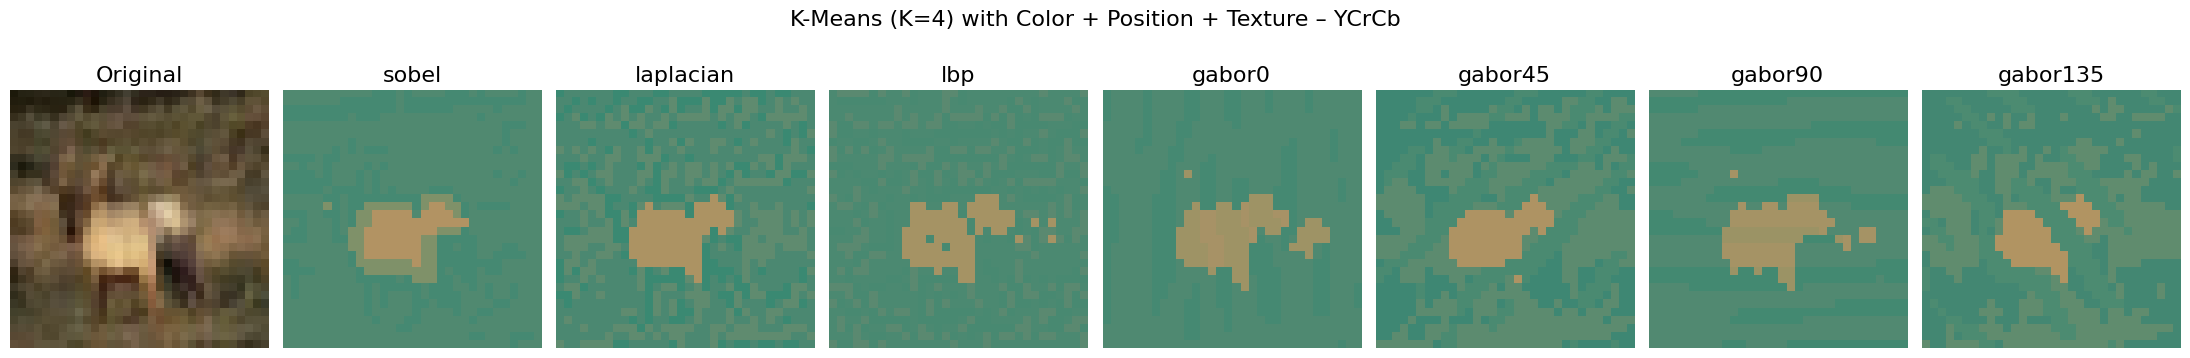

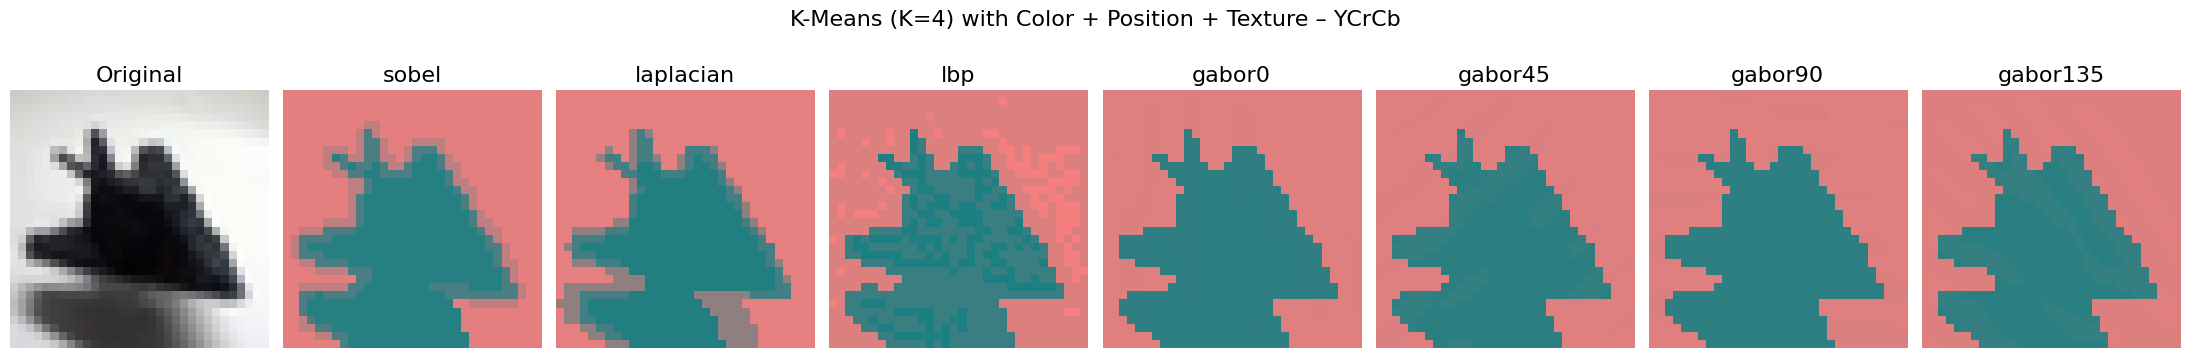

In [19]:
def visualize_texture_ablation_all_images(
    bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb,
    pos_weight=1.0, color_weight=1.0
):
    import matplotlib.pyplot as plt

    color_spaces = {
        "RGB": X_rgb,
        "HSV": X_hsv,
        "LAB": X_lab,
        "YCrCb": X_yCrCb
    }

    image_indices = [0, 10, 20]  # Horse, Deer, Airplane
    texture_names = ['sobel', 'laplacian', 'lbp', 'gabor0', 'gabor45', 'gabor90', 'gabor135']

    for space_name, X_space in color_spaces.items():
        for idx in image_indices:
            img_rgb = bicubic_imgs[idx]
            flat_color = X_space[idx]

            fig, axs = plt.subplots(1, len(texture_names) + 1, figsize=(22, 4))
            fig.suptitle(
                f"K-Means (K=4) with Color + Position + Texture – {space_name}",
                fontsize=16
            )

            axs[0].imshow(img_rgb)
            axs[0].set_title("Original", fontsize=16)
            axs[0].axis("off")

            for i, name in enumerate(texture_names):
                segmented = run_single_texture_feature_weighted(
                    img_rgb, flat_color, name,
                    pos_weight=pos_weight,
                    color_weight=color_weight
                )
                axs[i + 1].imshow((segmented * 255).astype(np.uint8))
                axs[i + 1].set_title(name, fontsize=16)
                axs[i + 1].axis("off")

            plt.tight_layout()
            plt.show()

visualize_texture_ablation_all_images(
    bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb,
    pos_weight=0.1, color_weight=1.0
)

## Evaluation Scores

In [21]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans
from collections import defaultdict
import pandas as pd

def compute_sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    return (edge_mag - edge_mag.min()) / (edge_mag.ptp() + 1e-5)

def get_combined_features_sobel(img, flat_color, pos_weight=0.1, color_weight=1.0):
    h, w = 32, 32
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0
    color = color.reshape(-1, 3) * color_weight

    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]]) * pos_weight

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = compute_sobel_magnitude(gray).reshape(-1, 1)

    return np.hstack([color, coords, sobel])  # final shape: (1024, 6)

def evaluate_clustering_metrics(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb):
    indices = [i for i in range(30)]
    color_spaces = {
        "RGB": X_rgb,
        "HSV": X_hsv,
        "LAB": X_lab,
        "YCrCb": X_yCrCb
    }

    results = defaultdict(list)

    for color_name, X_space in color_spaces.items():
        for idx in indices:
                img = bicubic_imgs[idx]
                flat_color = X_space[idx]

                features = get_combined_features_sobel(img, flat_color)

                kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
                labels = kmeans.fit_predict(features)
                
                if len(set(labels)) < 2:
                    continue  # skip degenerate cluster

                # Compute metrics
                dbi = davies_bouldin_score(features, labels)
                chi = calinski_harabasz_score(features, labels)
                silhouette = silhouette_score(features, labels)

                results['ColorSpace'].append(color_name)
                results['ImageIndex'].append(idx)
                results['DaviesBouldin'].append(dbi)
                results['CalinskiHarabasz'].append(chi)
                results['Silhouette'].append(silhouette)
                results['Inertia'].append(kmeans.inertia_)

    df = pd.DataFrame(results)
    return df

df_scores = evaluate_clustering_metrics(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb)
df_scores.groupby(["ColorSpace"]).mean(numeric_only = True).drop(columns=["ImageIndex"]).round(3).to_csv("kmeans_metrics_scores.csv", index=False)
display(df_scores.groupby(["ColorSpace"]).mean(numeric_only = True).drop(columns=["ImageIndex"]).round(3))

DaviesBouldin  CalinskiHarabasz  Silhouette  Inertia
ColorSpace                                                      
HSV                 0.991           775.344       0.432   42.098
LAB                 0.875          1067.876       0.459   20.652
RGB                 0.890          1267.155       0.459   35.111
YCrCb               0.877          1071.387       0.456   20.332

## Saving the Dataframe

In [22]:
import matplotlib.pyplot as plt

def save_dataframe_as_image(df, filename="table_output.png"):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Prepare DataFrame
table_df = (
    df_scores
    .groupby(["ColorSpace"])
    .mean(numeric_only=True)
    .drop(columns=["ImageIndex"])
    .round(3)
    .reset_index()
)

# Save it
save_dataframe_as_image(table_df, "kmeans_metrics_table.png")

## Finding the Evaluation Scores across all K values from 2 to 10

In [26]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.cluster import KMeans
from collections import defaultdict
import pandas as pd

def compute_sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    return (edge_mag - edge_mag.min()) / (edge_mag.ptp() + 1e-5)

def get_combined_features_sobel(img, flat_color, pos_weight=0.1, color_weight=1.0):
    h, w = 32, 32
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0
    color = color.reshape(-1, 3) * color_weight

    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]]) * pos_weight

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = compute_sobel_magnitude(gray).reshape(-1, 1)

    return np.hstack([color, coords, sobel])  # final shape: (1024, 6)

def evaluate_clustering_metrics(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb):
    indices = [i for i in range(30)]
    color_spaces = {
        "RGB": X_rgb,
        "HSV": X_hsv,
        "LAB": X_lab,
        "YCrCb": X_yCrCb
    }

    results = defaultdict(list)

    for color_name, X_space in color_spaces.items():
        for idx in indices:
            img = bicubic_imgs[idx]
            flat_color = X_space[idx]

            features = get_combined_features_sobel(img, flat_color)

            for k_value in range(2,11):
                kmeans = KMeans(n_clusters=k_value, n_init='auto', random_state=42)
                labels = kmeans.fit_predict(features)
                
                if len(set(labels)) < 2:
                    continue  # skip degenerate cluster

                # Compute metrics
                dbi = davies_bouldin_score(features, labels)
                chi = calinski_harabasz_score(features, labels)
                silhouette = silhouette_score(features, labels)

                results['ColorSpace'].append(color_name)
                results['ImageIndex'].append(idx)
                results["K"].append(k_value)
                results['DaviesBouldin'].append(dbi)
                results['CalinskiHarabasz'].append(chi)
                results['Silhouette'].append(silhouette)
                results['Inertia'].append(kmeans.inertia_)

    df = pd.DataFrame(results)
    return df

df_scores = evaluate_clustering_metrics(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb)
df_scores.groupby(["ColorSpace", "K"]).mean(numeric_only = True).drop(columns=["ImageIndex"]).round(3).to_csv("kmeans_metrics_scores.csv", index=False)
display(df_scores.groupby(["ColorSpace", "K"]).mean(numeric_only = True).drop(columns=["ImageIndex"]).round(3))

DaviesBouldin  CalinskiHarabasz  Silhouette  Inertia
ColorSpace K                                                       
HSV        2           1.067           735.723       0.449   78.979
           3           1.031           759.089       0.448   56.256
           4           0.996           756.059       0.432   42.788
           5           1.030           736.912       0.419   35.774
           6           1.041           731.182       0.391   30.563
           7           1.053           719.123       0.374   26.937
           8           1.057           695.554       0.374   24.424
           9           1.051           681.796       0.369   22.131
           10          1.050           676.145       0.364   20.366
LAB        2           0.935           931.246       0.489   44.500
           3           0.850          1080.867       0.493   27.403
           4           0.895          1053.565       0.448   20.937
           5           0.947          1028.014       0.412   17.009
           6           0.947          1003.552       0.391   14.406
           7           0.944          1003.750       0.385   12.412
           8           0.941          1011.216       0.378   10.917
           9           0.940          1004.256       0.375    9.756
           10          0.956           978.863       0.360    8.990
RGB        2           0.795          1353.547       0.535   69.221
           3           0.905          1257.723       0.475   47.500
           4           0.899          1246.493       0.454   35.391
           5           0.896          1238.617       0.432   28.418
           6           0.926          1230.505       0.409   23.904
           7           0.922          1209.381       0.408   20.584
           8           0.923          1208.570       0.400   18.099
           9           0.936          1207.270       0.391   16.353
           10          0.960          1179.452       0.372   15.033
YCrCb      2           0.937           926.861       0.490   43.836
           3           0.839          1088.967       0.496   26.856
           4           0.892          1045.064       0.451   20.722
           5           0.921          1033.445       0.431   16.667
           6           0.956          1026.725       0.390   13.988
           7           0.945          1008.769       0.386   12.237
           8           0.944          1006.823       0.372   10.699
           9           0.957           990.738       0.362    9.718
           10          0.956           977.966       0.360    8.851

In [27]:
df_scores.groupby(["ColorSpace", "K"]).mean(numeric_only = True).drop(columns=["ImageIndex"]).round(3).reset_index().to_csv("kmeans_metrics_scores.csv", index=False)

## Top-3 Best K Voting Strategy

In [28]:
import pandas as pd

def find_best_k_per_colorspace(df):
    """
    Find the best K-value for each color space based on voting from top-3 or bottom-3 ranks of each metric.
    """
    best_k_summary = {}

    for color in df["ColorSpace"].unique():
        subset = df[df["ColorSpace"] == color]

        # Metric rankings
        db_rank = subset.groupby("K")["DaviesBouldin"].mean().sort_values().head(3).index
        chi_rank = subset.groupby("K")["CalinskiHarabasz"].mean().sort_values(ascending=False).head(3).index
        sil_rank = subset.groupby("K")["Silhouette"].mean().sort_values(ascending=False).head(3).index
        inertia_rank = subset.groupby("K")["Inertia"].mean().sort_values().head(3).index

        # Voting: combine all top-3 K values
        combined = list(db_rank) + list(chi_rank) + list(sil_rank) + list(inertia_rank)
        vote_counts = pd.Series(combined).value_counts().sort_values(ascending=False)

        best_k = vote_counts.index[0]  # Most voted K
        best_k_summary[color] = {
            "Best_K": best_k,
            "Top_Ks_by_Count": dict(vote_counts)
        }

    return pd.DataFrame(best_k_summary).T

best_k_df = find_best_k_per_colorspace(df_scores)
print(best_k_df)

      Best_K                              Top_Ks_by_Count
RGB        2  {2: 3, 4: 3, 3: 2, 5: 1, 10: 1, 9: 1, 8: 1}
HSV        4  {4: 3, 3: 3, 5: 2, 2: 1, 10: 1, 9: 1, 8: 1}
LAB        3  {3: 3, 4: 3, 2: 2, 5: 1, 10: 1, 9: 1, 8: 1}
YCrCb      3  {3: 3, 4: 3, 5: 2, 2: 1, 10: 1, 9: 1, 8: 1}


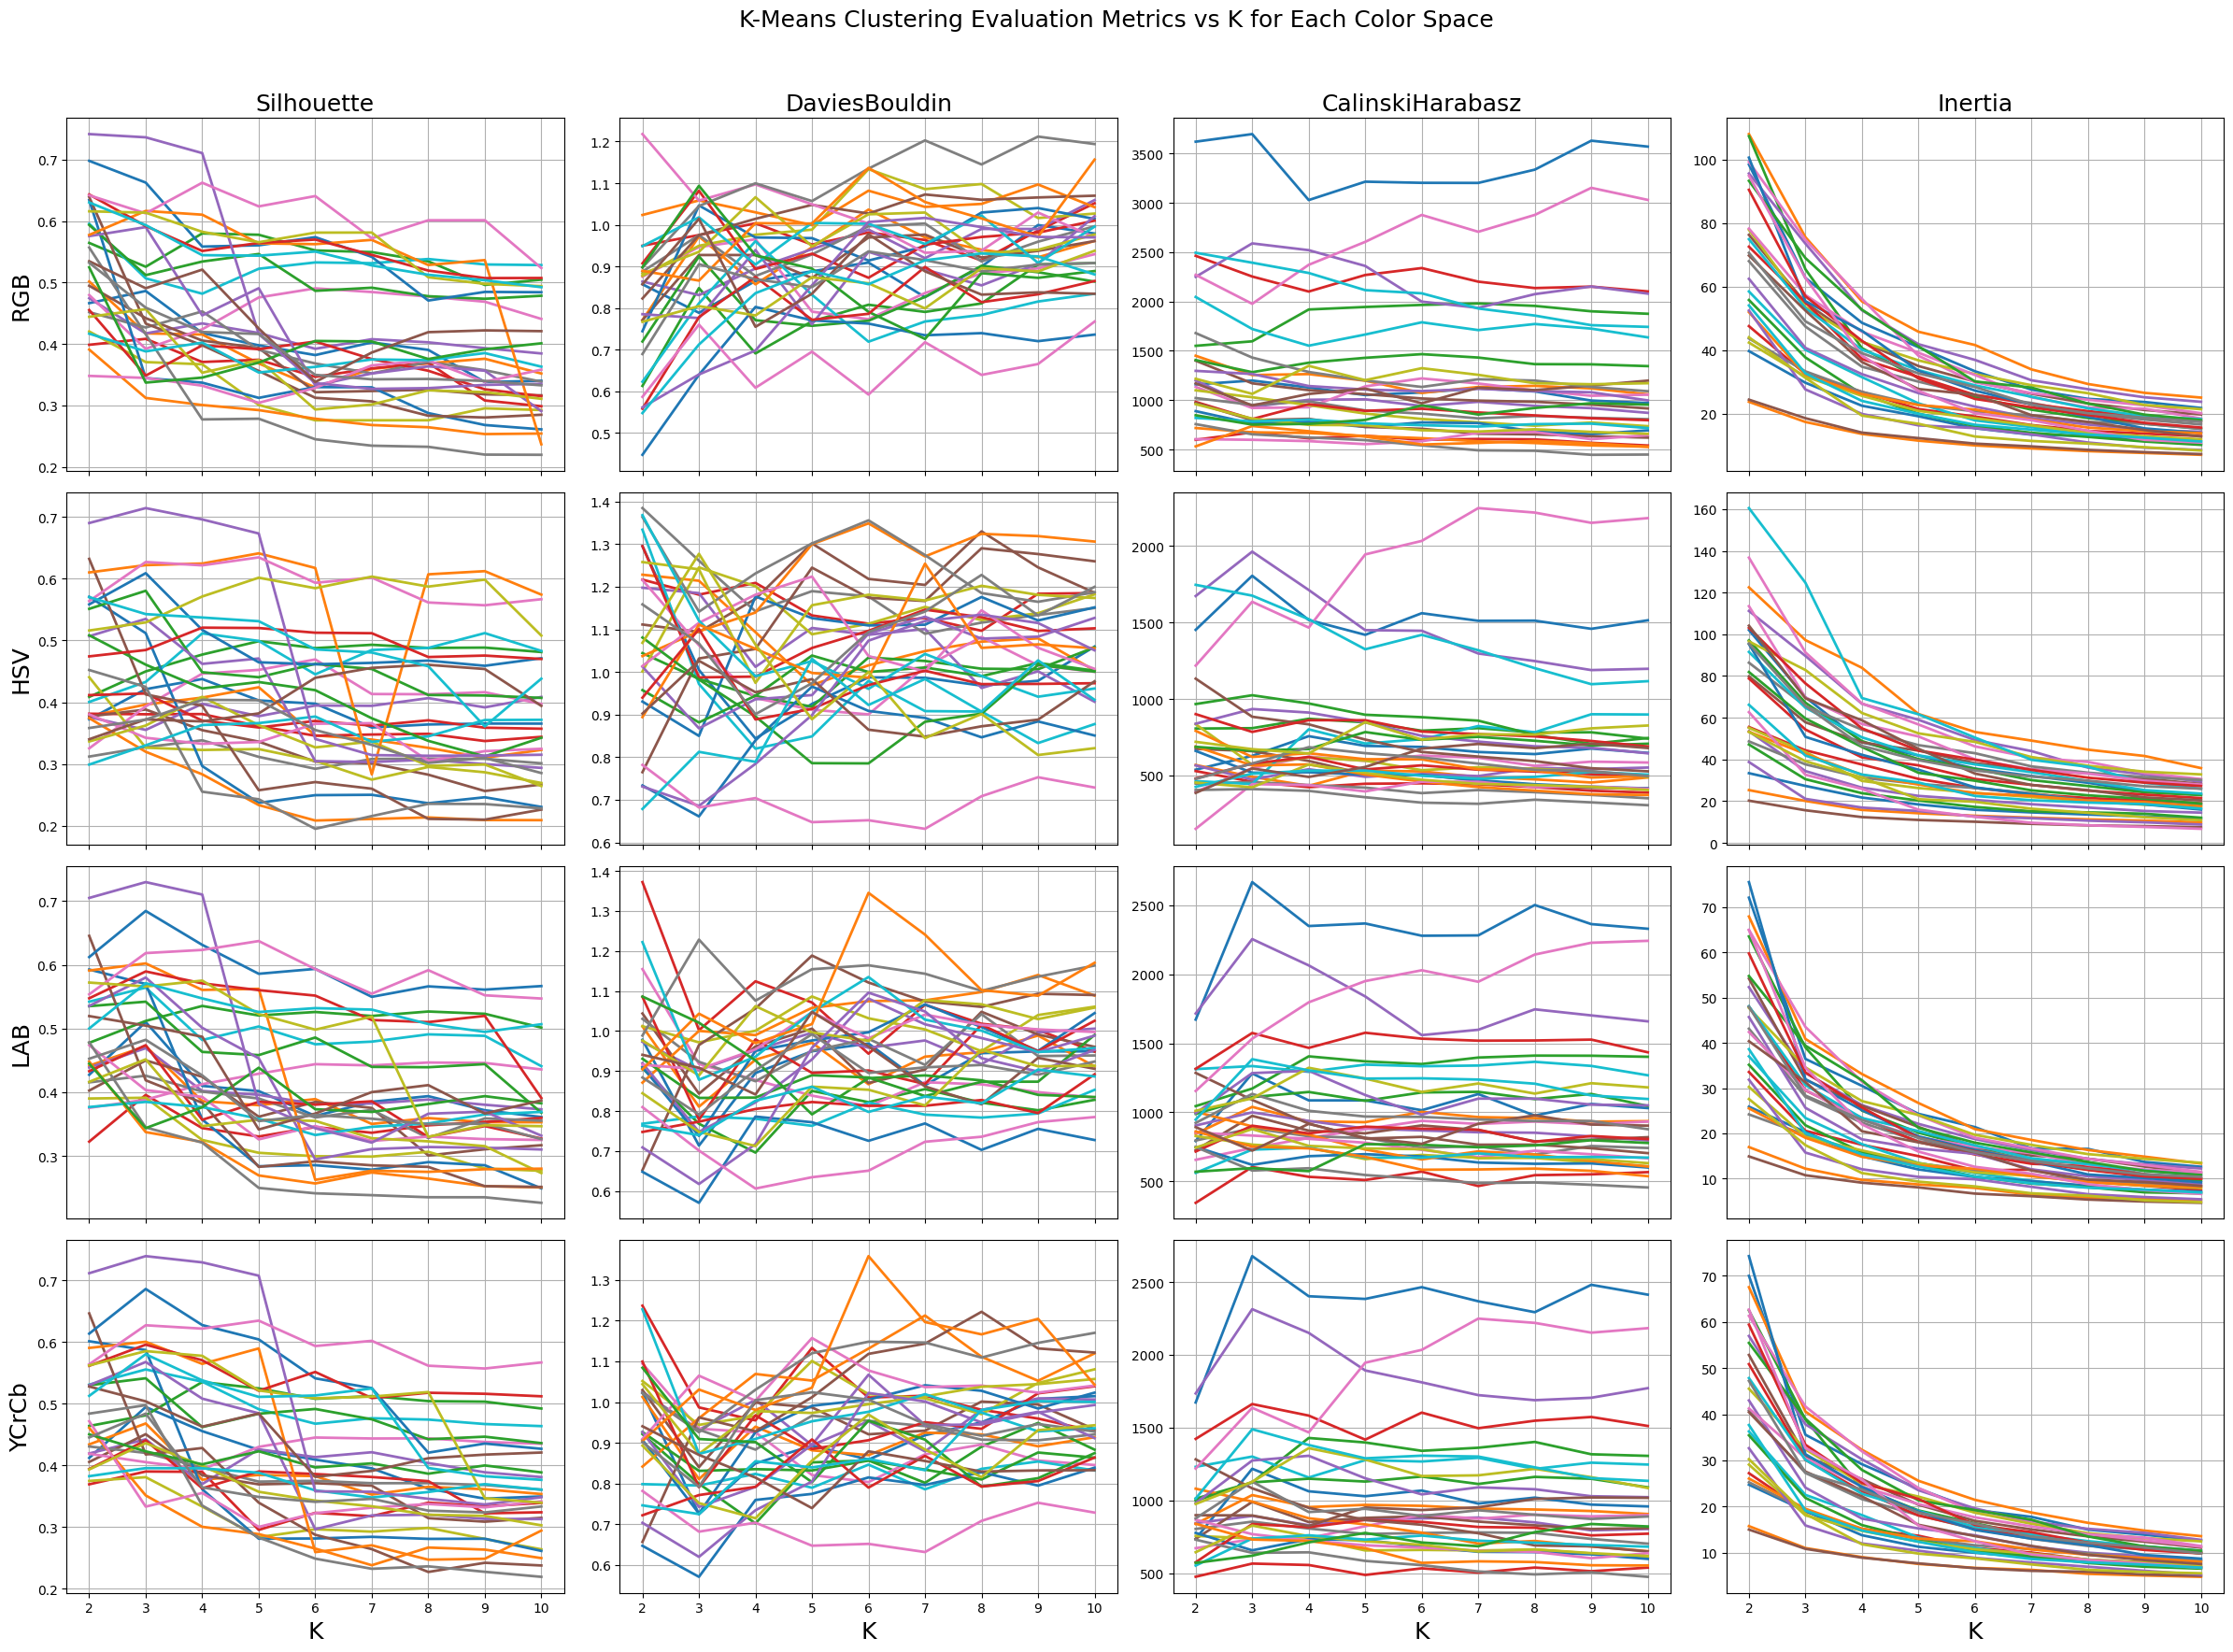

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import pandas as pd
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt

def compute_sobel_magnitude(gray):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag = np.sqrt(sobelx**2 + sobely**2)
    return (edge_mag - edge_mag.min()) / (edge_mag.ptp() + 1e-5)

def get_combined_features_sobel(img, flat_color, pos_weight=0.1, color_weight=1.0):
    h, w = 32, 32
    color = flat_color.reshape(h, w, 3).astype(np.float32) / 255.0
    color = color.reshape(-1, 3) * color_weight
    coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)
    coords = coords / np.array([[h, w]]) * pos_weight
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = compute_sobel_magnitude(gray).reshape(-1, 1)
    return np.hstack([color, coords, sobel])

def evaluate_k_range_all_30_images(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb, k_range = range(2, 11)):
    results = defaultdict(list)
    color_spaces = {
        "RGB": X_rgb,
        "HSV": X_hsv,
        "LAB": X_lab,
        "YCrCb": X_yCrCb
    }

    for color_name, X_space in color_spaces.items():
        for idx in range(30):
            img = bicubic_imgs[idx]
            flat_color = X_space[idx]
            features = get_combined_features_sobel(img, flat_color)

            for k in k_range:
                kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
                labels = kmeans.fit_predict(features)

                if len(set(labels)) < 2:
                    continue

                results["ColorSpace"].append(color_name)
                results["ImageIndex"].append(idx)
                results["K"].append(k)
                results["Inertia"].append(kmeans.inertia_)
                results["DaviesBouldin"].append(davies_bouldin_score(features, labels))
                results["CalinskiHarabasz"].append(calinski_harabasz_score(features, labels))
                results["Silhouette"].append(silhouette_score(features, labels))

    return pd.DataFrame(results)

def plot_k_metrics_grid(df):
    metrics = ['Silhouette', 'DaviesBouldin', 'CalinskiHarabasz', 'Inertia']
    color_spaces = df['ColorSpace'].unique()
    k_values = sorted(df['K'].unique())

    fig, axs = plt.subplots(len(color_spaces), len(metrics), figsize=(24, 18), sharex=True)
    fig.suptitle("K-Means Clustering Evaluation Metrics vs K for Each Color Space", fontsize=18)

    for i, color in enumerate(color_spaces):
        df_color = df[df["ColorSpace"] == color]
        for j, metric in enumerate(metrics):
            ax = axs[i, j]
            for idx in sorted(df_color['ImageIndex'].unique()):
                df_img = df_color[df_color["ImageIndex"] == idx]
                ax.plot(df_img['K'], df_img[metric], linewidth=2)

            if i == 0:
                ax.set_title(metric, fontsize = 18)
            if j == 0:
                ax.set_ylabel(color, fontsize = 18)

            ax.grid(True)
            if i == len(color_spaces) - 1:
                ax.set_xlabel("K", fontsize = 18)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("kmeans_metrics_plot.png", dpi = 300, bbox_inches = 'tight')
    plt.show()

df_scores = evaluate_k_range_all_30_images(bicubic_imgs, X_rgb, X_hsv, X_lab, X_yCrCb)
plot_k_metrics_grid(df_scores)